<a href="https://colab.research.google.com/github/juanserrano90/sophieML/blob/main/SophieML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import packages**

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn as sk
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [258]:
# from google.colab import drive
# drive.mount('/content/drive')

# **Read Training Data**

In [259]:
# training and testing stars
train_stars = ['HD185144', 'HD89269', 'HD9407', 'HD31501', 'HD205286']
test_stars = ['HD207897', 'HD224016', 'HD17820', 'BD+700503', 'TOI1273',
              'TOI1736', 'TOI2134', 'TOI1710', 'TOI1296', 'TOI1298',
              'HD88986', 'TOI1199', 'TOI1836', 'TOI5076']

In [260]:
# get the filenames
training_filenames = !ls /content/drive/MyDrive/Doctorado/Sophie_ML/data/train
training_filenames = training_filenames.s.split()

In [261]:
# read the files
columns_ccf = ['file_ccf','target','ccf_rv','ccf_rv_error','ccf_fwhm','ccf_contrast','ccf_span','berv','cal_ext_sn0','cal_ext_sn1','cal_ext_sn2','cal_ext_sn3','cal_ext_sn4','cal_ext_sn5','cal_ext_sn6','cal_ext_sn7','cal_ext_sn8','cal_ext_sn9','cal_ext_sn10','cal_ext_sn11','cal_ext_sn12','cal_ext_sn13','cal_ext_sn14','cal_ext_sn15','cal_ext_sn16','cal_ext_sn17','cal_ext_sn18','cal_ext_sn19','cal_ext_sn20','cal_ext_sn21','cal_ext_sn22','cal_ext_sn23','cal_ext_sn24','cal_ext_sn25','cal_ext_sn26','cal_ext_sn27','cal_ext_sn28','cal_ext_sn29','cal_ext_sn30','cal_ext_sn31','cal_ext_sn32','cal_ext_sn33','cal_ext_sn34','cal_ext_sn35','cal_ext_sn36','cal_ext_sn37','cal_ext_sn38','date_start','bjd']
columns_e2ds = ['file_e2ds','target','modo','shutter_time','ins_adcang','ins_adcnum','temp1_min','temp1_max','temp3_min','temp3_max','pres1_min','pres1_max','pres2_min','pres2_max','date_start','date_end','targ_radvel','airm_end','airm_start','tel_alt','guid_seeing','guid_sky_level','guid_alpha','guid_alpha_rms','guid_delta','guid_delta_rms','senti_text','senti_humi','senti_seeing','senti_tciel','senti_mag','bjd','targ_alpha','targ_delta','drift_rv','drift_nbcosmic','drift_rflux']

import pandas as pd
train_dfs = {}
for star in train_stars:
  train_dfs[star] = {}
  for filename in training_filenames:
    if star in filename:
      if 'ccf' in filename:
        key = 'ccf'
      elif 'e2ds' in filename:
        key = 'e2ds'
      else:
        continue
      if 'ccf' in filename:
        df = pd.read_table(f'/content/drive/MyDrive/Doctorado/Sophie_ML/data/train/{filename}', sep='\s+', names=columns_ccf)
        df.drop(columns=['date_start'], inplace=True)
      elif 'e2ds' in filename:
        df = pd.read_table(f'/content/drive/MyDrive/Doctorado/Sophie_ML/data/train/{filename}', sep='\s+', names=columns_e2ds)
        df.drop(columns=['target', 'bjd'], inplace=True)
      if key in train_dfs[star]:
        train_dfs[star][key] = pd.concat([train_dfs[star][key], df])
      else:
        train_dfs[star][key] = df

train_data = {}
for star in train_stars:
  train_data[star] = pd.concat([train_dfs[star]['ccf'], train_dfs[star]['e2ds']], axis=1)
  train_data[star]['date_start'] = pd.to_datetime(train_data[star]['date_start'])
  train_data[star]['date_end'] = pd.to_datetime(train_data[star]['date_end'])
  train_data[star]['mid_obs'] = train_data[star].date_start+(train_data[star].date_end-train_data[star].date_start)/2

del train_dfs

In [262]:
# drop all the 'HE' observations
for star in train_stars:
  a = len(train_data[star])
  train_data[star] = train_data[star][train_data[star]['modo'] != 'HE']
  print(a, '-->', len(train_data[star]))

1192 --> 641
721 --> 473
452 --> 265
22 --> 22
26 --> 26


In [263]:
train_data['HD185144'].date_start[0]+(train_data['HD185144'].date_end[0]-train_data['HD185144'].date_start[0])/2

Timestamp('2022-08-05 22:28:21.811000')

In [264]:
# read the temperatures file
temp_df = pd.read_csv('/content/drive/MyDrive/Doctorado/Sophie_ML/data/sensors_data/TempXL.txt')
temp_df['DATE'] = pd.to_datetime(temp_df['DATE'])

In [265]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63225 entries, 0 to 63224
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       63225 non-null  datetime64[ns]
 1   conteneur  63225 non-null  float64       
 2   grating    63225 non-null  float64       
 3   benchW     63225 non-null  float64       
 4   benchE     63225 non-null  float64       
 5   cryostat   63225 non-null  float64       
 6   coude      63225 non-null  float64       
 7   ferrule    63225 non-null  float64       
 8   shutter    63225 non-null  float64       
 9   spectro    63225 non-null  float64       
 10  obsroom    63225 non-null  float64       
 11  elecroom   63225 non-null  float64       
 12  pext       63225 non-null  float64       
 13  pint       63225 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 6.8 MB


In [266]:
# merge the dataframes based on the time interval
for star in train_stars:
  train_data[star] = pd.merge_asof(train_data[star].sort_values('date_start'), temp_df.sort_values('DATE'), left_on='mid_obs', right_on='DATE', direction='nearest')


# **Data Cleaning**

## NaNs

In [267]:
for star in train_stars:
  print(star)
  print(train_data[star].isna().sum().sum())

HD185144
39
HD89269
0
HD9407
0
HD31501
0
HD205286
0


In [268]:
# lets check HD185144
train_data['HD185144'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 98 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file_ccf        641 non-null    object        
 1   target          641 non-null    object        
 2   ccf_rv          641 non-null    float64       
 3   ccf_rv_error    641 non-null    float64       
 4   ccf_fwhm        641 non-null    float64       
 5   ccf_contrast    641 non-null    float64       
 6   ccf_span        641 non-null    float64       
 7   berv            641 non-null    object        
 8   cal_ext_sn0     641 non-null    float64       
 9   cal_ext_sn1     640 non-null    float64       
 10  cal_ext_sn2     640 non-null    float64       
 11  cal_ext_sn3     640 non-null    float64       
 12  cal_ext_sn4     640 non-null    float64       
 13  cal_ext_sn5     640 non-null    float64       
 14  cal_ext_sn6     640 non-null    float64       
 15  cal_ex

In [269]:
train_data['HD185144'].iloc[7]

,7
file_ccf,SOPHIE.2018-06-24T22:17:02.111_newccf_G2_A.fits
target,HD185144
ccf_rv,26.734199
ccf_rv_error,0.533396
ccf_fwhm,9.635992
...,...
spectro,20.0908
obsroom,25.1305
elecroom,18.8157
pext,938.47505


In [270]:
# drop any rows that contain 'newccf' in the 'file_ccf' column
for star in train_stars:
  train_data[star] = train_data[star][~train_data[star]['file_ccf'].str.contains('newccf')]

In [271]:
# convert HD185144 berv column to float64
train_data['HD185144']['berv'] = train_data['HD185144']['berv'].astype('float64')

In [272]:
train_data['HD185144'] = train_data['HD185144'].dropna()
print(len(train_data['HD185144']))

640


## Bad Values and Outliers

### Drop Low SNR points

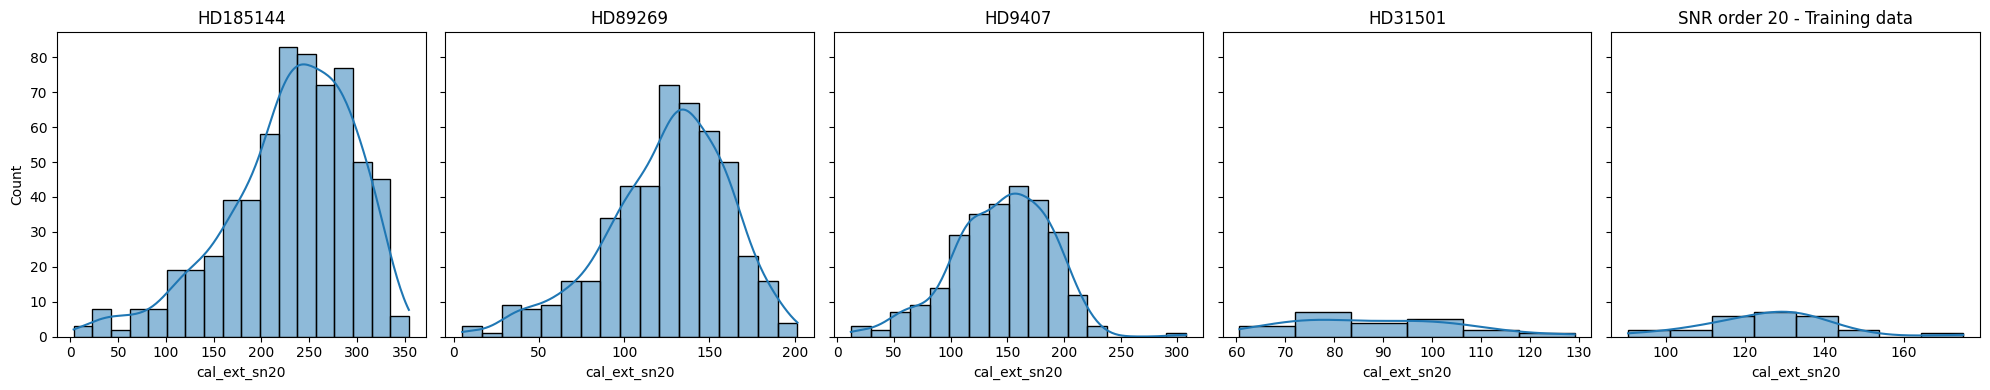

In [273]:
# histogram of the SNR at a medium order
fig, axes = plt.subplots(1, len(train_stars), figsize=(20, 4), sharey=True)

for i, star in enumerate(train_stars):
  sns.histplot(train_data[star]['cal_ext_sn20'], ax=axes[i], kde=True)
  axes[i].set_title(star)

plt.tight_layout()
plt.title('SNR order 20 - Training data')
plt.savefig('drive/MyDrive/Doctorado/Sophie_ML/sn20-train.png', dpi=200)
plt.show()

In [274]:
# how many points are below median-3sigma
for star in train_stars:
  print(star, (train_data[star]['cal_ext_sn20'] < (train_data[star]['cal_ext_sn20'].median()-3*train_data[star]['cal_ext_sn20'].std())).sum())

HD185144 9
HD89269 3
HD9407 2
HD31501 0
HD205286 0


In [275]:
# how many points are below 75 SNR
for star in train_stars:
  print(star, (train_data[star]['cal_ext_sn20'] < 75).sum())

HD185144 21
HD89269 48
HD9407 20
HD31501 6
HD205286 0


In [276]:
# drop points with SNR below 75
for star in train_stars:
  train_data[star] = train_data[star][train_data[star]['cal_ext_sn20'] > 75]
  print(len(train_data[star]))

619
425
245
16
26


### Test days

In [277]:
# spotting test days
# these are days where the instrument was being calibrated and there are many observartions of the same constants in the same night
# should be removed
for star in train_stars:
  print(star)
  print(train_data[star]['date_start'].dt.date.value_counts()[:4])

HD185144
date_start
2019-08-26    13
2019-08-27     6
2022-09-15     2
2023-07-09     2
Name: count, dtype: int64
HD89269
date_start
2021-04-01    10
2021-02-26     9
2024-05-20     2
2021-02-17     2
Name: count, dtype: int64
HD9407
date_start
2023-10-10    2
2022-11-11    2
2018-12-04    2
2018-12-01    2
Name: count, dtype: int64
HD31501
date_start
2018-01-11    1
2018-01-12    1
2018-01-18    1
2018-01-19    1
Name: count, dtype: int64
HD205286
date_start
2018-07-15    2
2018-07-28    2
2018-07-26    2
2018-07-17    1
Name: count, dtype: int64


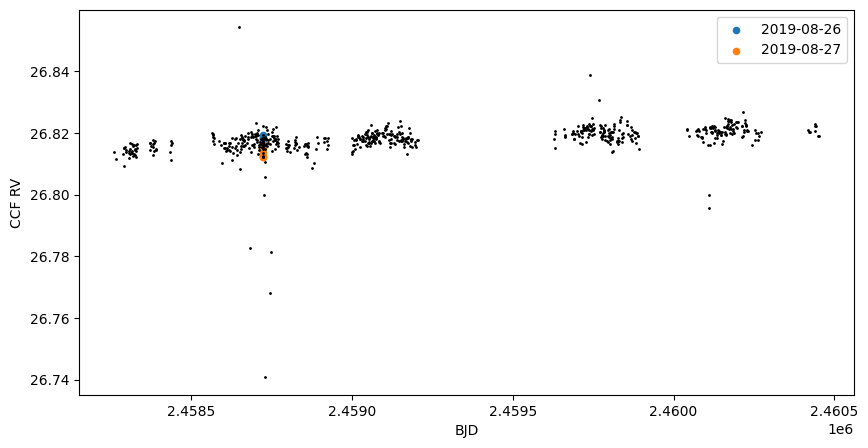

In [278]:
# plot the points on 2019-08-26 and 2019-08-27 on a ccf_rv vs bjd scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
mask1 = train_data['HD185144']['date_start'].dt.date == pd.to_datetime('2019-08-26').date()
mask2 = train_data['HD185144']['date_start'].dt.date == pd.to_datetime('2019-08-27').date()
ax.scatter(train_data['HD185144']['bjd'][mask1], train_data['HD185144']['ccf_rv'][mask1], label='2019-08-26', s=20)
ax.scatter(train_data['HD185144']['bjd'][mask2], train_data['HD185144']['ccf_rv'][mask2], label='2019-08-27', s=20)
ax.scatter(train_data['HD185144']['bjd'], train_data['HD185144']['ccf_rv'], c='k', marker='o', s=1)
ax.set_xlabel('BJD')
ax.set_ylabel('CCF RV')
plt.legend()
plt.show()

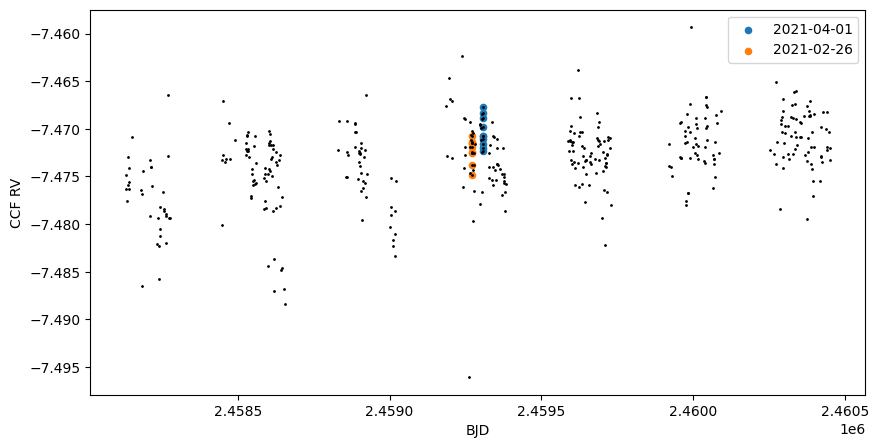

In [279]:
# prompt: plot the HD89269 points on 2021-04-01 and 2021-02-26 on a ccf_rv vs bjd scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
mask1 = train_data['HD89269']['date_start'].dt.date == pd.to_datetime('2021-04-01').date()
mask2 = train_data['HD89269']['date_start'].dt.date == pd.to_datetime('2021-02-26').date()
ax.scatter(train_data['HD89269']['bjd'][mask1], train_data['HD89269']['ccf_rv'][mask1], label='2021-04-01', s=20)
ax.scatter(train_data['HD89269']['bjd'][mask2], train_data['HD89269']['ccf_rv'][mask2], label='2021-02-26', s=20)
ax.scatter(train_data['HD89269']['bjd'], train_data['HD89269']['ccf_rv'], c='k', marker='o', s=1)
ax.set_xlabel('BJD')
ax.set_ylabel('CCF RV')
plt.legend()
plt.show()

In [280]:
total = 0
for star in train_stars:
  total += len(train_data[star])
print(total)

1331


In [281]:
# remove the test days
train_data['HD185144'] = train_data['HD185144'][train_data['HD185144']['date_start'].dt.date != pd.to_datetime('2019-08-26').date()]
train_data['HD185144'] = train_data['HD185144'][train_data['HD185144']['date_start'].dt.date != pd.to_datetime('2019-08-27').date()]
train_data['HD89269'] = train_data['HD89269'][train_data['HD89269']['date_start'].dt.date != pd.to_datetime('2021-04-01').date()]
train_data['HD89269'] = train_data['HD89269'][train_data['HD89269']['date_start'].dt.date != pd.to_datetime('2021-02-26').date()]

In [282]:
total = 0
for star in train_stars:
  total += len(train_data[star])
print(total)

1293


### RV outliers

Outliers for HD185144: 18
Outliers for HD89269: 19
Outliers for HD9407: 11
Outliers for HD31501: 0
Outliers for HD205286: 0
Total outliers: 48


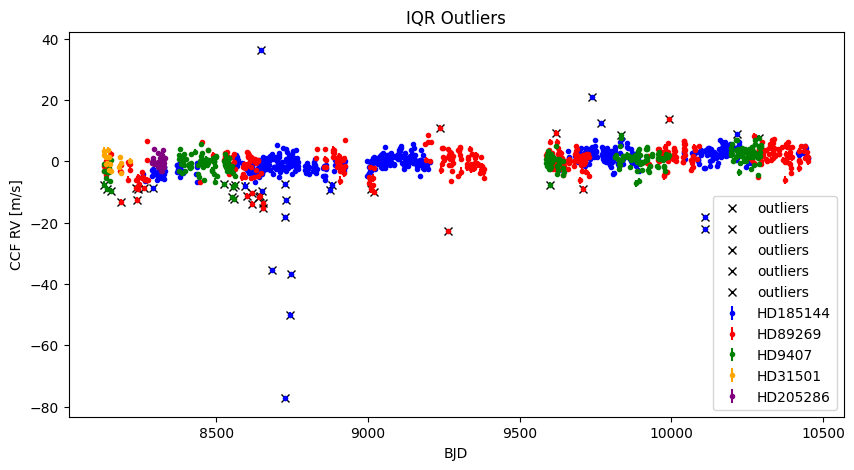

In [283]:
# look for iqr outliers in the ccf_rv column for each star
outliers_rv = {}
total_outliers = 0
for star in train_stars:
  Q1 = train_data[star]['ccf_rv'].quantile(0.25)
  Q3 = train_data[star]['ccf_rv'].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers_rv[star] = train_data[star][(train_data[star]['ccf_rv'] < lower_bound) | (train_data[star]['ccf_rv'] > upper_bound)]
  print(f"Outliers for {star}:", len(outliers_rv[star]))
  total_outliers += len(outliers_rv[star])
print(f"Total outliers: {total_outliers}")

# plot the ccf_rv vs bjd for the 5 train stars with different colors and use errorbars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, star in enumerate(train_stars):
  ax.errorbar(train_data[star]['bjd']-2450000, (train_data[star]['ccf_rv']-train_data[star]['ccf_rv'].mean())*1e3,
              train_data[star]['ccf_rv_error'], fmt='.', color=colors[i], label=star)
  ax.plot(outliers_rv[star]['bjd']-2450000, (outliers_rv[star]['ccf_rv']-train_data[star]['ccf_rv'].mean())*1e3, 'x', color='k', label='outliers')
ax.set_xlabel('BJD')
ax.set_ylabel('CCF RV [m/s]')
plt.title('IQR Outliers')
plt.legend()
plt.show()

Outliers for HD185144: 9
Outliers for HD89269: 7
Outliers for HD9407: 2
Outliers for HD31501: 0
Outliers for HD205286: 0
Total outliers: 18


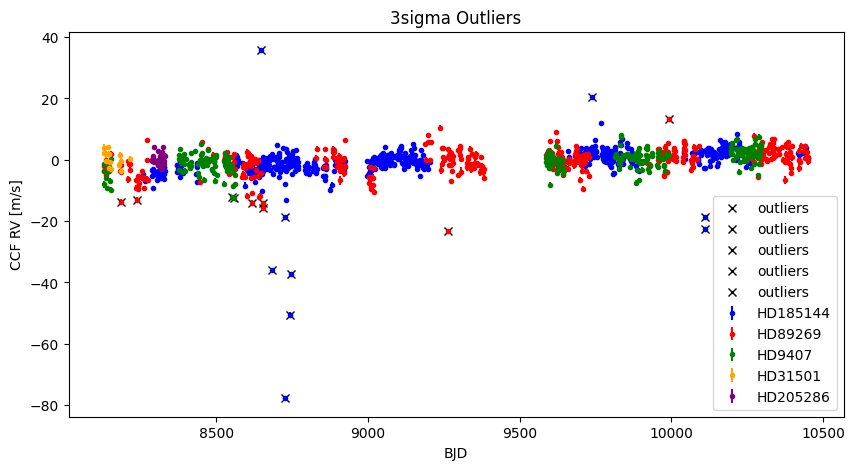

In [284]:
# look for 3sigma outliers in the ccf_rv column for each star
outliers_rv = {}
total_outliers = 0
for star in train_stars:
  median = train_data[star]['ccf_rv'].median()
  std = train_data[star]['ccf_rv'].std()
  lower_bound = median - 3 * std
  upper_bound = median + 3 * std
  outliers_rv[star] = train_data[star][(train_data[star]['ccf_rv'] < lower_bound) | (train_data[star]['ccf_rv'] > upper_bound)]
  print(f"Outliers for {star}:", len(outliers_rv[star]))
  total_outliers += len(outliers_rv[star])
print(f"Total outliers: {total_outliers}")
# plot the ccf_rv vs bjd for the 5 train stars with different colors and use errorbars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, star in enumerate(train_stars):
  ax.errorbar(train_data[star]['bjd']-2450000, (train_data[star]['ccf_rv']-train_data[star]['ccf_rv'].median())*1e3,
              train_data[star]['ccf_rv_error'], fmt='.', color=colors[i], label=star)
  ax.plot(outliers_rv[star]['bjd']-2450000, (outliers_rv[star]['ccf_rv']-train_data[star]['ccf_rv'].median())*1e3, 'x', color='k', label='outliers')
ax.set_xlabel('BJD')
ax.set_ylabel('CCF RV [m/s]')
plt.title('3sigma Outliers')
plt.legend()
plt.savefig('drive/MyDrive/Doctorado/Sophie_ML/3sigma-outliers-rv.png', dpi=200)
plt.show()

In [285]:
total = 0
for star in train_stars:
  total += len(train_data[star])
print(total)

1293


In [286]:
# remove outliers
method = 'iqr'
sigmas = 3

for star in train_stars:
  if method == 'iqr':
    Q1 = train_data[star]['ccf_rv'].quantile(0.25)
    Q3 = train_data[star]['ccf_rv'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_data[star] = train_data[star][(train_data[star]['ccf_rv'] >= lower_bound) & (train_data[star]['ccf_rv'] <= upper_bound)]
  elif method == '3sigma':
    median = train_data[star]['ccf_rv'].median()
    std = train_data[star]['ccf_rv'].std()
    lower_bound = median - sigmas * std
    upper_bound = median + sigmas * std
    train_data[star] = train_data[star][(train_data[star]['ccf_rv'] >= lower_bound) & (train_data[star]['ccf_rv'] <= upper_bound)]

In [287]:
total = 0
for star in train_stars:
  total += len(train_data[star])
print(total)

1245


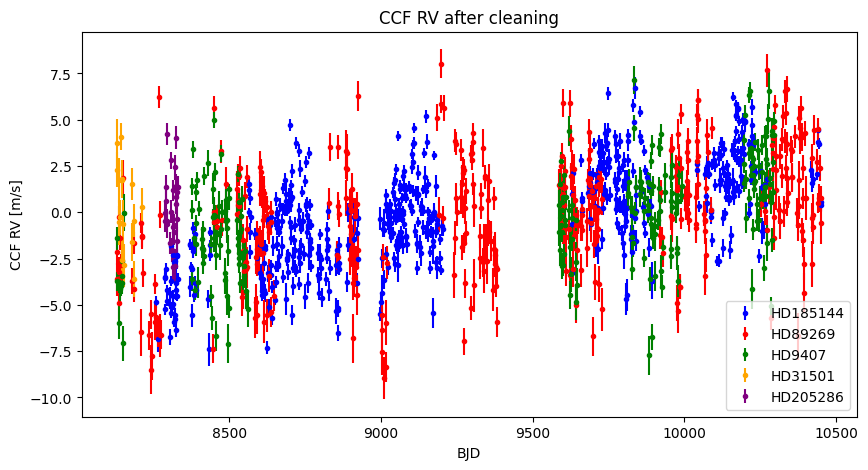

In [288]:
# plot the ccf_rv vs bjd for the 5 train stars with different colors and use errorbars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, star in enumerate(train_stars):
  ax.errorbar(train_data[star]['bjd']-2450000, (train_data[star]['ccf_rv']-train_data[star]['ccf_rv'].median())*1e3,
              train_data[star]['ccf_rv_error'], fmt='.', color=colors[i], label=star)
ax.set_xlabel('BJD')
ax.set_ylabel('CCF RV [m/s]')
plt.title('CCF RV after cleaning')
plt.legend()
plt.savefig('drive/MyDrive/Doctorado/Sophie_ML/ccf_rvs.png', dpi=200)
plt.show()

### Zero values in sensors

In [289]:
# look for columns with more than 10 3-sigma outliers
for star in train_stars:
  for column in train_data[star].columns:
    if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
      num_outliers = (train_data[star][column] < (train_data[star][column].mean() - 3 * train_data[star][column].std())).sum() + \
                     (train_data[star][column] > (train_data[star][column].mean() + 3 * train_data[star][column].std())).sum()
      if num_outliers > 10:
        print(f"Star: {star}, Column: {column}, Outliers: {num_outliers}")

Star: HD185144, Column: ccf_rv_error, Outliers: 11
Star: HD185144, Column: ccf_fwhm, Outliers: 17
Star: HD185144, Column: ccf_contrast, Outliers: 17
Star: HD185144, Column: ccf_span, Outliers: 12
Star: HD185144, Column: shutter_time, Outliers: 18
Star: HD185144, Column: pres2_min, Outliers: 56
Star: HD185144, Column: pres2_max, Outliers: 55
Star: HD185144, Column: airm_end, Outliers: 12
Star: HD185144, Column: airm_start, Outliers: 12
Star: HD185144, Column: guid_sky_level, Outliers: 11
Star: HD185144, Column: targ_delta, Outliers: 53
Star: HD185144, Column: pint, Outliers: 55
Star: HD89269, Column: shutter_time, Outliers: 12


In [290]:
# look for columns with more than 10 iqr outliers
for star in train_stars:
  for column in train_data[star].columns:
    if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
      Q1 = train_data[star][column].quantile(0.25)
      Q3 = train_data[star][column].quantile(0.75)
      IQR = Q3 - Q1
      num_outliers = ((train_data[star][column] < (Q1 - 1.5 * IQR)) | (train_data[star][column] > (Q3 + 1.5 * IQR))).sum()
      if num_outliers > 10:
        print(f"Star: {star}, Column: {column}, Outliers: {num_outliers}")

Star: HD185144, Column: ccf_rv_error, Outliers: 42
Star: HD185144, Column: ccf_fwhm, Outliers: 34
Star: HD185144, Column: ccf_contrast, Outliers: 50
Star: HD185144, Column: ccf_span, Outliers: 16
Star: HD185144, Column: berv, Outliers: 12
Star: HD185144, Column: shutter_time, Outliers: 69
Star: HD185144, Column: pres1_min, Outliers: 22
Star: HD185144, Column: pres1_max, Outliers: 22
Star: HD185144, Column: pres2_min, Outliers: 86
Star: HD185144, Column: pres2_max, Outliers: 85
Star: HD185144, Column: airm_end, Outliers: 61
Star: HD185144, Column: airm_start, Outliers: 55
Star: HD185144, Column: tel_alt, Outliers: 35
Star: HD185144, Column: guid_seeing, Outliers: 76
Star: HD185144, Column: guid_sky_level, Outliers: 57
Star: HD185144, Column: guid_alpha, Outliers: 34
Star: HD185144, Column: guid_alpha_rms, Outliers: 34
Star: HD185144, Column: guid_delta, Outliers: 55
Star: HD185144, Column: guid_delta_rms, Outliers: 24
Star: HD185144, Column: senti_text, Outliers: 76
Star: HD185144, Colu

In [291]:
# print the number of cero values for each star in pres2_min, pres2_max and pint in percentage with 2 decimals
for star in train_stars:
  print(star)
  print('pres2_min: {:.2f}%'.format((train_data[star]['pres2_min'] == 0).sum()/len(train_data[star])*100))
  print('pres2_max: {:.2f}%'.format((train_data[star]['pres2_max'] == 0).sum()/len(train_data[star])*100))
  print('pint: {:.2f}%'.format((train_data[star]['pint'] == 0).sum()/len(train_data[star])*100))

HD185144
pres2_min: 9.62%
pres2_max: 9.45%
pint: 9.45%
HD89269
pres2_min: 15.25%
pres2_max: 15.25%
pint: 15.25%
HD9407
pres2_min: 20.51%
pres2_max: 20.51%
pint: 20.51%
HD31501
pres2_min: 0.00%
pres2_max: 0.00%
pint: 0.00%
HD205286
pres2_min: 0.00%
pres2_max: 0.00%
pint: 0.00%


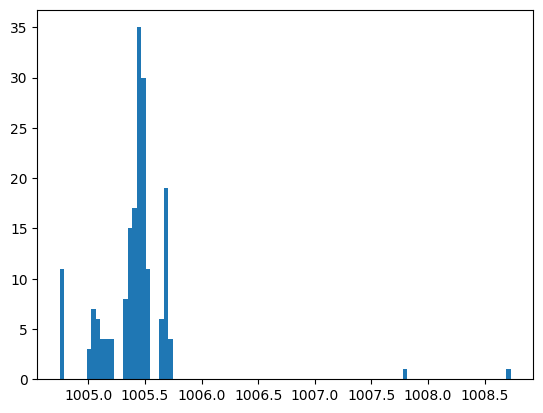

In [292]:
plt.hist(train_data['HD9407']['pint'][train_data['HD9407']['pres2_min']>600], bins=100)
plt.show()

In [293]:
# for each column and each star, print the number of zero values and the mean and standard deviation
for star in train_stars:
  print(f"Star: {star}")
  for column in train_data[star].columns:
    if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
      num_zeros = (train_data[star][column] == 0).sum()
      mean_value = train_data[star][column].mean()
      std_value = train_data[star][column].std()
      if num_zeros > 0:
        print(f"  Column: {column}, Zero values: {num_zeros}, Mean: {mean_value:.2f}, Std: {std_value:.2f}")

Star: HD185144
  Column: ccf_span, Zero values: 11, Mean: -0.00, Std: 0.00
  Column: shutter_time, Zero values: 3, Mean: 307.01, Std: 80.31
  Column: ins_adcang, Zero values: 2, Mean: 196.54, Std: 126.14
  Column: temp1_min, Zero values: 1, Mean: 20.16, Std: 0.84
  Column: temp1_max, Zero values: 1, Mean: 20.16, Std: 0.84
  Column: temp3_min, Zero values: 1, Mean: 20.41, Std: 0.85
  Column: temp3_max, Zero values: 1, Mean: 20.42, Std: 0.85
  Column: pres1_min, Zero values: 1, Mean: 936.60, Std: 39.20
  Column: pres1_max, Zero values: 1, Mean: 936.65, Std: 39.20
  Column: pres2_min, Zero values: 56, Mean: 908.65, Std: 296.74
  Column: pres2_max, Zero values: 55, Mean: 910.38, Std: 294.36
  Column: guid_seeing, Zero values: 54, Mean: 2.30, Std: 1.23
  Column: guid_sky_level, Zero values: 1, Mean: 318.45, Std: 981.35
  Column: guid_alpha, Zero values: 65, Mean: -0.03, Std: 0.06
  Column: guid_alpha_rms, Zero values: 8, Mean: 0.28, Std: 0.11
  Column: guid_delta, Zero values: 74, Mean: 0.0

In [294]:
# for each star, if the number of zero values for a column is less than 20 but greater than 0, and the mean of that column different from 0, replace the zero values by the median. print the number of replaced zeros
for star in train_stars:
  print(f"Star: {star}")
  for column in train_data[star].columns:
    if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
      num_zeros = (train_data[star][column] == 0).sum()
      median_value = train_data[star][column].median()
      if 0 < num_zeros < 20 and abs(median_value) > 2:
        median_value = train_data[star][column][train_data[star][column] != 0].median()
        train_data[star][column] = train_data[star][column].replace(0, median_value)
        print(f"  Column: {column}, Replaced {num_zeros} zero values with median: {median_value:.2f}")

Star: HD185144
  Column: shutter_time, Replaced 3 zero values with median: 300.02
  Column: ins_adcang, Replaced 2 zero values with median: 241.00
  Column: temp1_min, Replaced 1 zero values with median: 20.20
  Column: temp1_max, Replaced 1 zero values with median: 20.20
  Column: temp3_min, Replaced 1 zero values with median: 20.45
  Column: temp3_max, Replaced 1 zero values with median: 20.45
  Column: pres1_min, Replaced 1 zero values with median: 938.37
  Column: pres1_max, Replaced 1 zero values with median: 938.38
  Column: guid_sky_level, Replaced 1 zero values with median: 54.96
  Column: senti_humi, Replaced 2 zero values with median: 9.10
  Column: senti_seeing, Replaced 4 zero values with median: 9999.00
Star: HD89269
  Column: shutter_time, Replaced 1 zero values with median: 600.04
  Column: guid_sky_level, Replaced 1 zero values with median: 67.58
  Column: senti_humi, Replaced 3 zero values with median: 9999.00
  Column: senti_mag, Replaced 1 zero values with median: 99

In [295]:
# for each column and each star, print the number of zero values and the median and standard deviation
for star in train_stars:
  print(f"Star: {star}")
  for column in train_data[star].columns:
    if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
      num_zeros = (train_data[star][column] == 0).sum()
      median_value = train_data[star][column].median()
      std_value = train_data[star][column].std()
      if num_zeros > 0 and abs(median_value) > 0.2:
        print(f"  Column: {column}, Zero values: {num_zeros}, Median: {median_value:.2f}, Std: {std_value:.2f}")

Star: HD185144
  Column: pres2_min, Zero values: 56, Median: 1005.41, Std: 296.74
  Column: pres2_max, Zero values: 55, Median: 1005.41, Std: 294.36
  Column: guid_seeing, Zero values: 54, Median: 2.17, Std: 1.23
  Column: guid_alpha_rms, Zero values: 8, Median: 0.26, Std: 0.11
  Column: guid_delta_rms, Zero values: 8, Median: 0.24, Std: 0.11
  Column: pint, Zero values: 55, Median: 1005.41, Std: 294.36
Star: HD89269
  Column: pres2_min, Zero values: 59, Median: 1005.49, Std: 361.90
  Column: pres2_max, Zero values: 59, Median: 1005.49, Std: 361.90
  Column: guid_seeing, Zero values: 34, Median: 2.35, Std: 1.36
  Column: guid_alpha_rms, Zero values: 7, Median: 0.27, Std: 0.17
  Column: guid_delta_rms, Zero values: 7, Median: 0.24, Std: 0.10
  Column: drift_rv, Zero values: 1, Median: -1.88, Std: 3.49
  Column: pint, Zero values: 59, Median: 1005.49, Std: 361.90
Star: HD9407
  Column: pres2_min, Zero values: 48, Median: 1005.41, Std: 406.85
  Column: pres2_max, Zero values: 48, Median: 

In [296]:
# pres2_min, pres2_max and pint are from the same sensor, all have the same zeros
# replace them by the median, but keep in mind that for some stars we are replacing ~20% of the data

# replace the zeros on pres2_min, pres2_max and pint by the median
for star in train_stars:
  for column in ['pres2_min', 'pres2_max', 'pint']:
    num_zeros = (train_data[star][column] == 0).sum()
    median_value = train_data[star][column][train_data[star][column] != 0].median()
    train_data[star][column] = train_data[star][column].replace(0, median_value)
    print(f"Star: {star}, Column: {column}, Replaced {num_zeros} zero values with median: {median_value:.2f}")

Star: HD185144, Column: pres2_min, Replaced 56 zero values with median: 1005.42
Star: HD185144, Column: pres2_max, Replaced 55 zero values with median: 1005.42
Star: HD185144, Column: pint, Replaced 55 zero values with median: 1005.42
Star: HD89269, Column: pres2_min, Replaced 59 zero values with median: 1005.50
Star: HD89269, Column: pres2_max, Replaced 59 zero values with median: 1005.50
Star: HD89269, Column: pint, Replaced 59 zero values with median: 1005.50
Star: HD9407, Column: pres2_min, Replaced 48 zero values with median: 1005.45
Star: HD9407, Column: pres2_max, Replaced 48 zero values with median: 1005.45
Star: HD9407, Column: pint, Replaced 48 zero values with median: 1005.45
Star: HD31501, Column: pres2_min, Replaced 0 zero values with median: 1004.76
Star: HD31501, Column: pres2_max, Replaced 0 zero values with median: 1004.76
Star: HD31501, Column: pint, Replaced 0 zero values with median: 1004.76
Star: HD205286, Column: pres2_min, Replaced 0 zero values with median: 1004

### Bad values in senti_columns

In [297]:
# make a grid of plots where at each row there's histograms of one of the senti_columns, and each column is one of the stars
# senti_columns = ['senti_text', 'senti_humi', 'senti_seeing', 'senti_tciel', 'senti_mag']

# fig, axes = plt.subplots(len(senti_columns), len(train_stars), figsize=(20, 15))

# for i, column in enumerate(senti_columns):
#   for j, star in enumerate(train_stars):
#     sns.histplot(train_data[star][column], ax=axes[i, j], kde=True)
#     if i == 0:
#       axes[i, j].set_title(star)
#     if j == 0:
#       axes[i, j].set_ylabel(column)

# plt.tight_layout()
# plt.show()

In [298]:
# all this columns are very unreliable, lets drop them for all stars
for star in train_stars:
  train_data[star].drop(columns=['senti_text', 'senti_humi', 'senti_seeing', 'senti_tciel', 'senti_mag'], inplace=True)

### Guid_sky_level

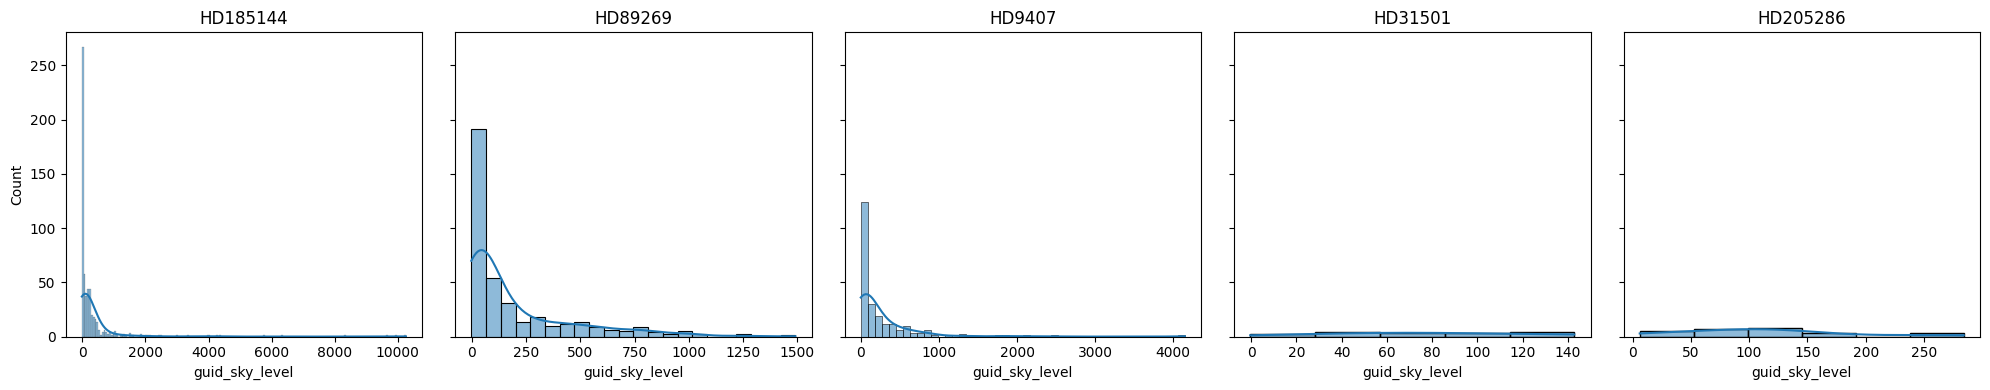

In [299]:
# histogram of guid_sky_level for all stars
fig, axes = plt.subplots(1, len(train_stars), figsize=(20, 4), sharey=True)

for i, star in enumerate(train_stars):
  sns.histplot(train_data[star]['guid_sky_level'], ax=axes[i], kde=True)
  axes[i].set_title(star)

plt.tight_layout()
plt.show()

In [300]:
# is there any negative values in guid_sky_level?
for star in train_stars:
  print(star, (train_data[star]['guid_sky_level'] <= 0).sum())

HD185144 3
HD89269 1
HD9407 3
HD31501 1
HD205286 0


In [301]:
# replace negative and zero values it by the median, then convert the column to logarithmic scale for all stars
for star in train_stars:
  median_value = train_data[star]['guid_sky_level'][train_data[star]['guid_sky_level'] > 0].median()
  train_data[star]['guid_sky_level'] = train_data[star]['guid_sky_level'].replace(0, median_value)
  train_data[star]['guid_sky_level'] = np.log(train_data[star]['guid_sky_level'])
  train_data[star]['guid_sky_level'] = train_data[star]['guid_sky_level'].replace(np.nan, np.log(median_value))

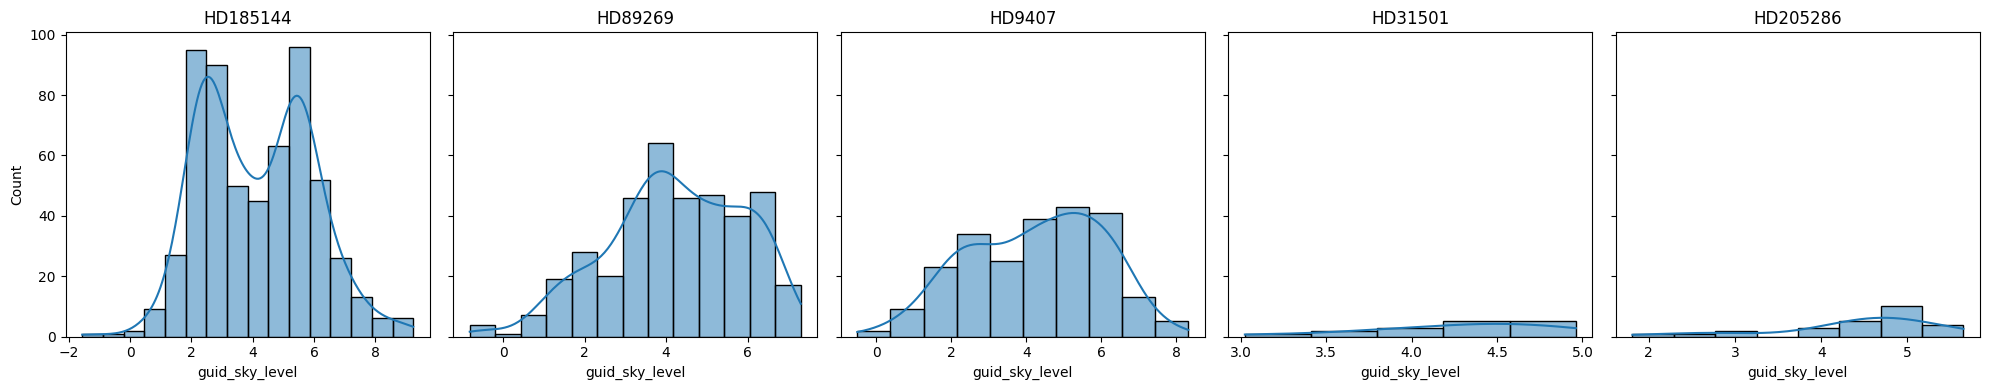

In [302]:
# prompt: histogram of guid_sky_level for all stars
fig, axes = plt.subplots(1, len(train_stars), figsize=(20, 4), sharey=True)

for i, star in enumerate(train_stars):
  sns.histplot(train_data[star]['guid_sky_level'], ax=axes[i], kde=True)
  axes[i].set_title(star)

plt.tight_layout()
plt.show()

### More outliers?

In [303]:
# look for columns with more than 10 3-sigma outliers
for star in train_stars:
  for column in train_data[star].columns:
    if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
      num_outliers = (train_data[star][column] < (train_data[star][column].mean() - 3 * train_data[star][column].std())).sum() + \
                     (train_data[star][column] > (train_data[star][column].mean() + 3 * train_data[star][column].std())).sum()
      if num_outliers > 10:
        print(f"Star: {star}, Column: {column}, 3sigma Outliers: {num_outliers}")

# look for columns with more than 10 iqr outliers
for star in train_stars:
  for column in train_data[star].columns:
    if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
      Q1 = train_data[star][column].quantile(0.25)
      Q3 = train_data[star][column].quantile(0.75)
      IQR = Q3 - Q1
      num_outliers = ((train_data[star][column] < (Q1 - 1.5 * IQR)) | (train_data[star][column] > (Q3 + 1.5 * IQR))).sum()
      if num_outliers > 10:
        print(f"Star: {star}, Column: {column}, IQR Outliers: {num_outliers}")

Star: HD185144, Column: ccf_rv_error, 3sigma Outliers: 11
Star: HD185144, Column: ccf_fwhm, 3sigma Outliers: 17
Star: HD185144, Column: ccf_contrast, 3sigma Outliers: 17
Star: HD185144, Column: ccf_span, 3sigma Outliers: 12
Star: HD185144, Column: shutter_time, 3sigma Outliers: 15
Star: HD185144, Column: pres2_min, 3sigma Outliers: 14
Star: HD185144, Column: pres2_max, 3sigma Outliers: 14
Star: HD185144, Column: airm_end, 3sigma Outliers: 12
Star: HD185144, Column: airm_start, 3sigma Outliers: 12
Star: HD185144, Column: targ_delta, 3sigma Outliers: 53
Star: HD185144, Column: pint, 3sigma Outliers: 14
Star: HD89269, Column: shutter_time, 3sigma Outliers: 11
Star: HD185144, Column: ccf_rv_error, IQR Outliers: 42
Star: HD185144, Column: ccf_fwhm, IQR Outliers: 34
Star: HD185144, Column: ccf_contrast, IQR Outliers: 50
Star: HD185144, Column: ccf_span, IQR Outliers: 16
Star: HD185144, Column: berv, IQR Outliers: 12
Star: HD185144, Column: shutter_time, IQR Outliers: 66
Star: HD185144, Colum

### Shutter time

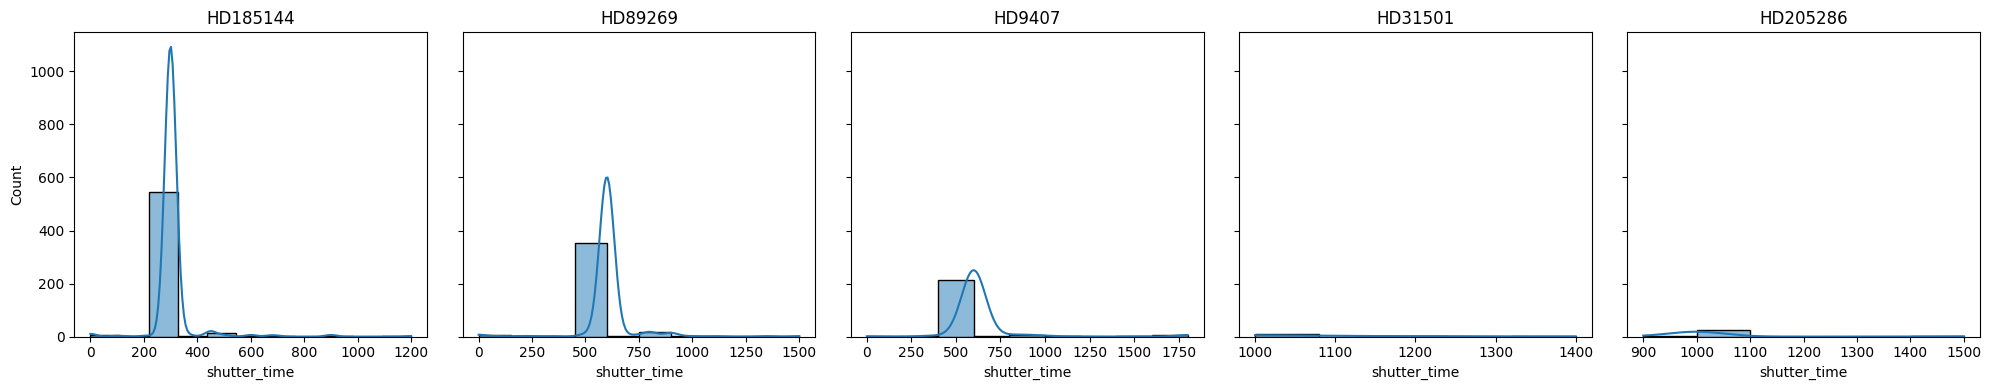

In [304]:
# histogram of shutter_time for all stas
fig, axes = plt.subplots(1, len(train_stars), figsize=(20, 4), sharey=True)

for i, star in enumerate(train_stars):
  sns.histplot(train_data[star]['shutter_time'], ax=axes[i], kde=True)
  axes[i].set_title(star)

plt.tight_layout()
plt.show()

In [305]:
# number of low values in shutter time for each star
for star in train_stars:
  print(star, (train_data[star]['shutter_time'] < 200).sum())

HD185144 7
HD89269 6
HD9407 1
HD31501 0
HD205286 0


In [306]:
# locate observations with shutter_time < 1 and print their SNR
for star in train_stars:
  low_shutter_obs = train_data[star][train_data[star]['shutter_time'] < 200]
  print(f"Star: {star}")
  for index, row in low_shutter_obs.iterrows():
    print(f"  Index: {index}, Shutter Time: {row['shutter_time']}, SNR: {row['cal_ext_sn20']}")

Star: HD185144
  Index: 6, Shutter Time: 0.512, SNR: 273.964176653499
  Index: 195, Shutter Time: 1.536, SNR: 276.929320114062
  Index: 208, Shutter Time: 1.28, SNR: 198.142421862484
  Index: 249, Shutter Time: 120.013, SNR: 140.362067895445
  Index: 499, Shutter Time: 0.768, SNR: 184.35641953417
  Index: 519, Shutter Time: 84.4, SNR: 88.6589341443115
  Index: 629, Shutter Time: 0.512, SNR: 157.955029652689
Star: HD89269
  Index: 26, Shutter Time: 92.29, SNR: 185.0788946207
  Index: 146, Shutter Time: 1.28, SNR: 93.5961411548732
  Index: 171, Shutter Time: 1.792, SNR: 201.644589549676
  Index: 178, Shutter Time: 1.024, SNR: 112.046892232843
  Index: 295, Shutter Time: 0.512, SNR: 153.138944317931
  Index: 471, Shutter Time: 184.544, SNR: 89.9750513000041
Star: HD9407
  Index: 45, Shutter Time: 0.512, SNR: 113.99310372588
Star: HD31501
Star: HD205286


In [307]:
# replace shutter_time < 50 with the median
for star in train_stars:
  median_value = train_data[star]['shutter_time'][train_data[star]['shutter_time'] >= 50].median()
  for value in train_data[star]['shutter_time'][train_data[star]['shutter_time'] < 50]:
    train_data[star]['shutter_time'] = train_data[star]['shutter_time'].replace(value, median_value)

In [308]:
for star in train_stars:
  print(star, (train_data[star]['shutter_time'] < 50).sum())

HD185144 0
HD89269 0
HD9407 0
HD31501 0
HD205286 0


### Airmass

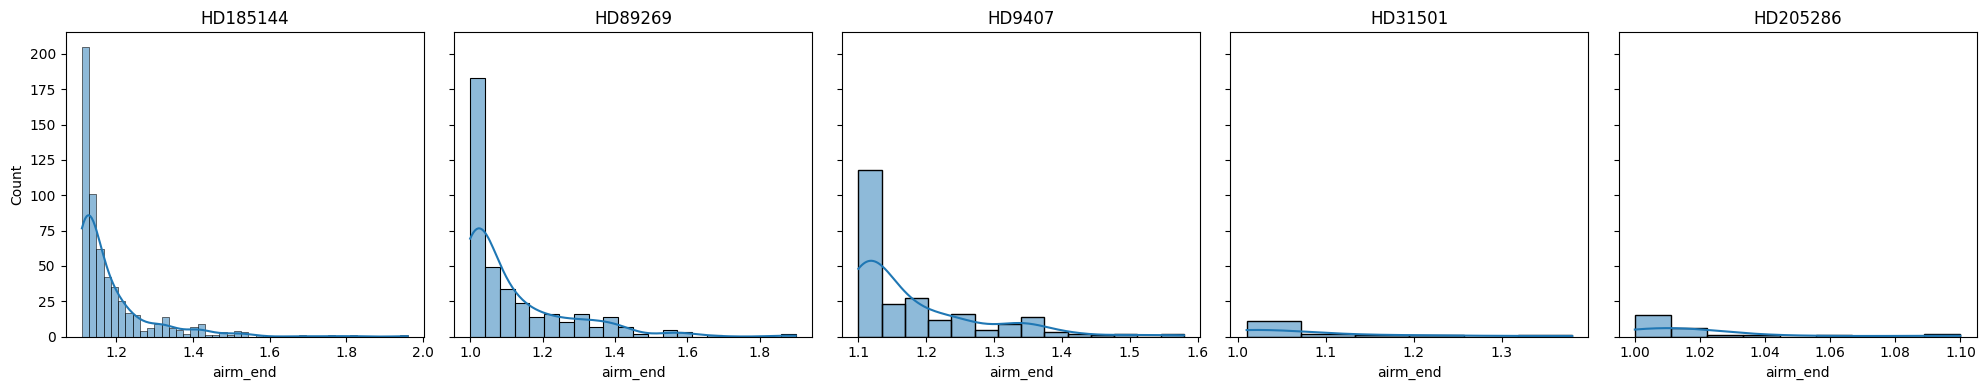

In [309]:
fig, axes = plt.subplots(1, len(train_stars), figsize=(20, 4), sharey=True)

for i, star in enumerate(train_stars):
  sns.histplot(train_data[star]['airm_end'], ax=axes[i], kde=True)
  axes[i].set_title(star)

plt.tight_layout()
plt.show()

In [310]:
# look for columns with more than 10 3-sigma outliers
for star in train_stars:
  column = 'airm_start'
  if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
    num_outliers = (train_data[star][column] < (train_data[star][column].mean() - 3 * train_data[star][column].std())).sum() + \
                   (train_data[star][column] > (train_data[star][column].mean() + 3 * train_data[star][column].std())).sum()
    if num_outliers > 0:
      print(f"Star: {star}, Column: {column}, 3sigma Outliers: {num_outliers}")

# look for columns with more than 10 iqr outliers
for star in train_stars:
  column = 'airm_start'
  if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
    Q1 = train_data[star][column].quantile(0.25)
    Q3 = train_data[star][column].quantile(0.75)
    IQR = Q3 - Q1
    num_outliers = ((train_data[star][column] < (Q1 - 1.5 * IQR)) | (train_data[star][column] > (Q3 + 1.5 * IQR))).sum()
    if num_outliers > 0:
      print(f"Star: {star}, Column: {column}, IQR Outliers: {num_outliers}")

Star: HD185144, Column: airm_start, 3sigma Outliers: 12
Star: HD89269, Column: airm_start, 3sigma Outliers: 9
Star: HD9407, Column: airm_start, 3sigma Outliers: 5
Star: HD205286, Column: airm_start, 3sigma Outliers: 1
Star: HD185144, Column: airm_start, IQR Outliers: 55
Star: HD89269, Column: airm_start, IQR Outliers: 16
Star: HD9407, Column: airm_start, IQR Outliers: 10
Star: HD31501, Column: airm_start, IQR Outliers: 2
Star: HD205286, Column: airm_start, IQR Outliers: 3


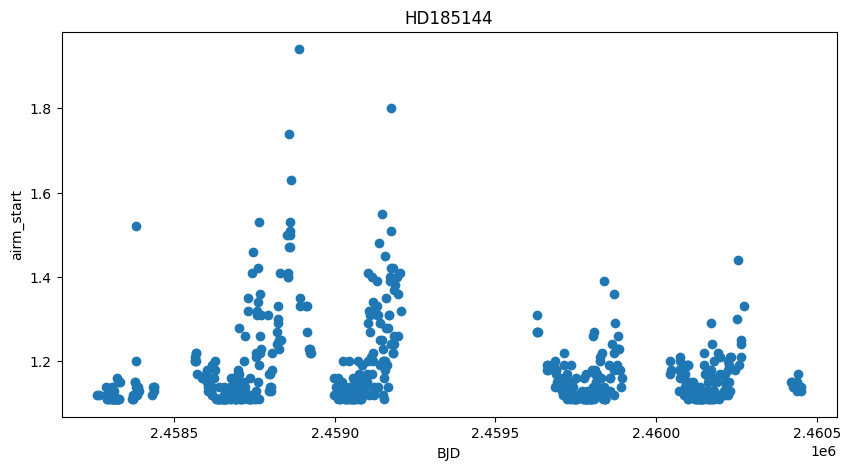

In [311]:
# let's check the airmass for HD185144
plt.figure(figsize=(10,5))
plt.scatter(train_data['HD185144']['bjd'], train_data['HD185144']['airm_start'])
plt.xlabel('BJD')
plt.ylabel('airm_start')
plt.title('HD185144')
plt.show()

In [312]:
# one more check for outliers in all columns
for star in train_stars:
  for column in train_data[star].columns:
    if train_data[star][column].dtype != 'object' and train_data[star][column].dtype != '<M8[ns]':
      num_outliers = (train_data[star][column] < (train_data[star][column].mean() - 3 * train_data[star][column].std())).sum() + \
                     (train_data[star][column] > (train_data[star][column].mean() + 3 * train_data[star][column].std())).sum()
      if num_outliers > 10:
        print(f"Star: {star}, Column: {column}, 3sigma Outliers: {num_outliers}")

Star: HD185144, Column: ccf_rv_error, 3sigma Outliers: 11
Star: HD185144, Column: ccf_fwhm, 3sigma Outliers: 17
Star: HD185144, Column: ccf_contrast, 3sigma Outliers: 17
Star: HD185144, Column: ccf_span, 3sigma Outliers: 12
Star: HD185144, Column: shutter_time, 3sigma Outliers: 11
Star: HD185144, Column: pres2_min, 3sigma Outliers: 14
Star: HD185144, Column: pres2_max, 3sigma Outliers: 14
Star: HD185144, Column: airm_end, 3sigma Outliers: 12
Star: HD185144, Column: airm_start, 3sigma Outliers: 12
Star: HD185144, Column: targ_delta, 3sigma Outliers: 53
Star: HD185144, Column: pint, 3sigma Outliers: 14


### RV errors

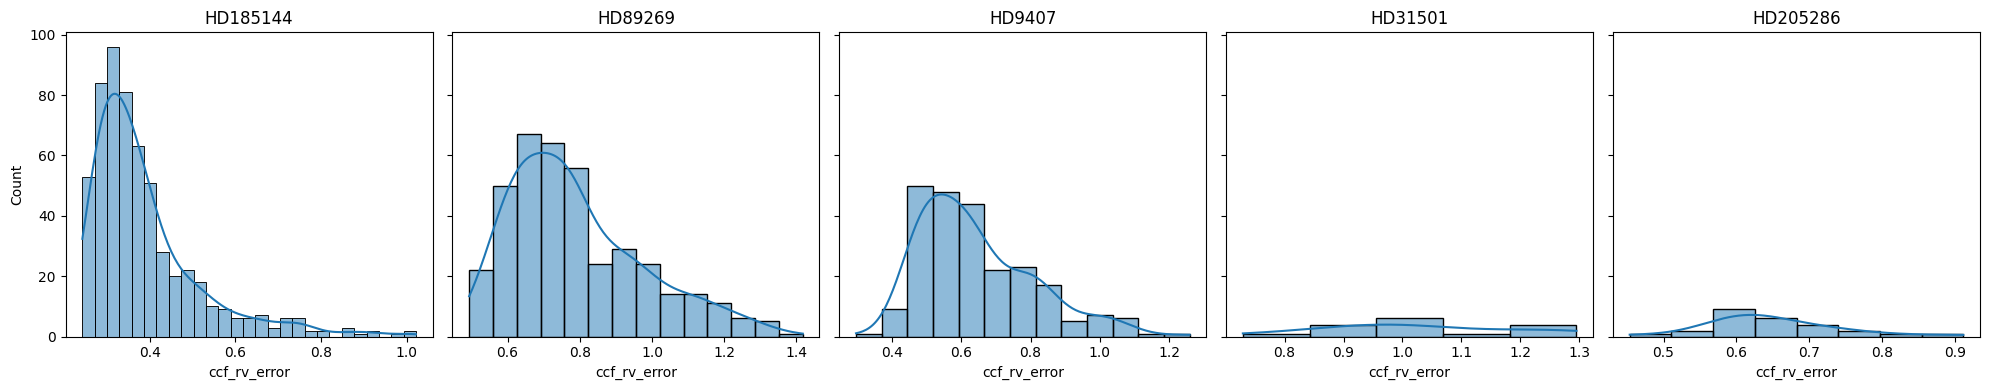

In [313]:
# plot ccf_rv_error histograms for all stars
fig, axes = plt.subplots(1, len(train_stars), figsize=(20, 4), sharey=True)

for i, star in enumerate(train_stars):
  sns.histplot(train_data[star]['ccf_rv_error'], ax=axes[i], kde=True)
  axes[i].set_title(star)

plt.tight_layout()
plt.show()

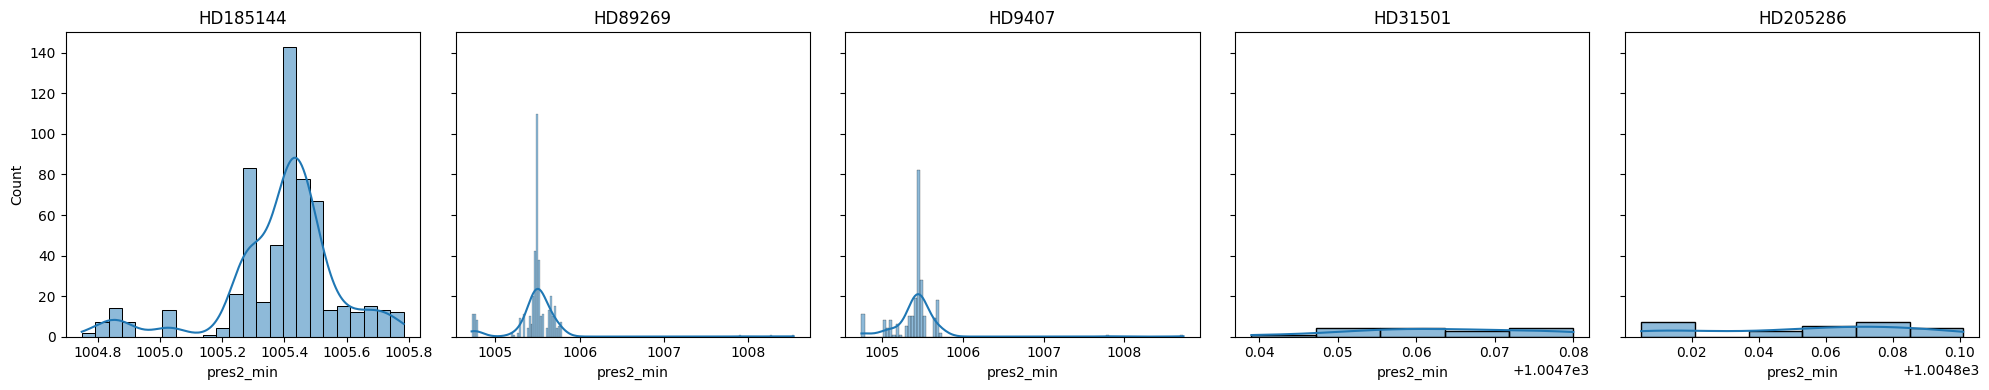

In [314]:
fig, axes = plt.subplots(1, len(train_stars), figsize=(20, 4), sharey=True)

for i, star in enumerate(train_stars):
  sns.histplot(train_data[star]['pres2_min'], ax=axes[i], kde=True)
  axes[i].set_title(star)

plt.tight_layout()
plt.show()

## Plot the RVs

In [315]:
# convert bjd to bjd-2450000
# and ccf_rv to m/s
for star in train_stars:
  train_data[star]['bjd'] = train_data[star]['bjd'] - 2450000.0
  train_data[star]['ccf_rv'] = train_data[star]['ccf_rv'] * 1e3

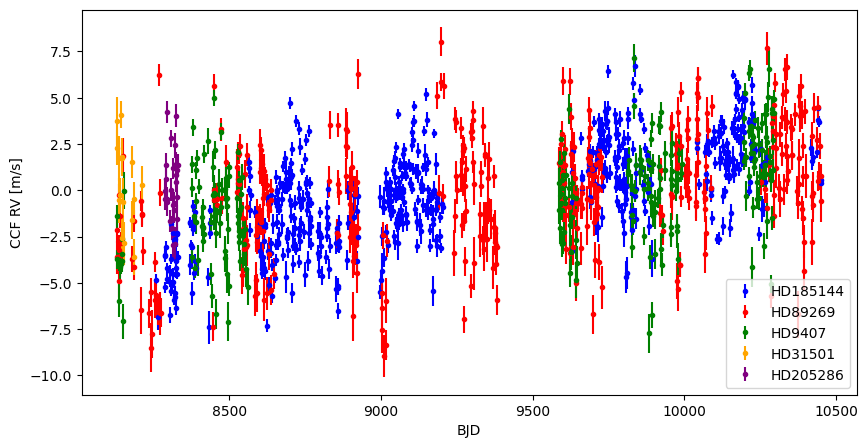

In [316]:
# plot the ccf_rv vs bjd for the 5 train stars with different colors and use errorbars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, star in enumerate(train_stars):
  ax.errorbar(train_data[star]['bjd'], (train_data[star]['ccf_rv']-train_data[star]['ccf_rv'].median()),
              train_data[star]['ccf_rv_error'], fmt='.', color=colors[i], label=star)
ax.set_xlabel('BJD')
ax.set_ylabel('CCF RV [m/s]')
plt.legend()
plt.savefig('drive/MyDrive/Doctorado/Sophie_ML/final-rvs.png', dpi=200)
plt.show()

In [317]:
train_data['HD89269']['cal_ext_sn20'][(train_data['HD89269']['bjd']>9000) & (train_data['HD89269']['bjd']<9100)]

,cal_ext_sn20
155,83.215780
156,120.331054
158,86.228673
159,138.311839
162,91.900808
163,87.076931
164,129.359371
166,115.529574


## Remove the activity from HD185144

### Read the Master Constant

In [318]:
# IMPORTANTE, RESTAR PRIMERO LAS CORRECIONES Y LUEGO CENTRAR EN CERO
# !!!!!!!! ERA ESTE EL PROBLEMA DEL OFFSET?

In [319]:
master = pd.read_table('/content/drive/MyDrive/Doctorado/Sophie_ML/data/master_constant/master_constant_neda2024.rdb', sep='\s+')
master['date'] = master['date'] - 50000

In [320]:
master.head()

,date,vrmoy,bissmoy
0,5783.8797,-10.8454,10.2001
1,5785.5460,-10.5431,9.9501
2,5787.0515,-10.3618,8.9001
3,5788.4402,-10.1805,7.8501
4,5789.9388,-10.3618,7.9001


In [321]:
# the series of the master constant ends before the series of HD185144
print(master['date'].max())
print(train_data['HD185144']['bjd'].max())

10240.36
10451.572863339912


In [322]:
# how many points are outside the correction?
print(len(train_data['HD185144'][train_data['HD185144']['bjd'] > master['date'].max()]))

17


In [323]:
# build a function of bjd interpolating vrmoy
from scipy.interpolate import interp1d
f = interp1d(master['date'], master['vrmoy'], kind='linear')

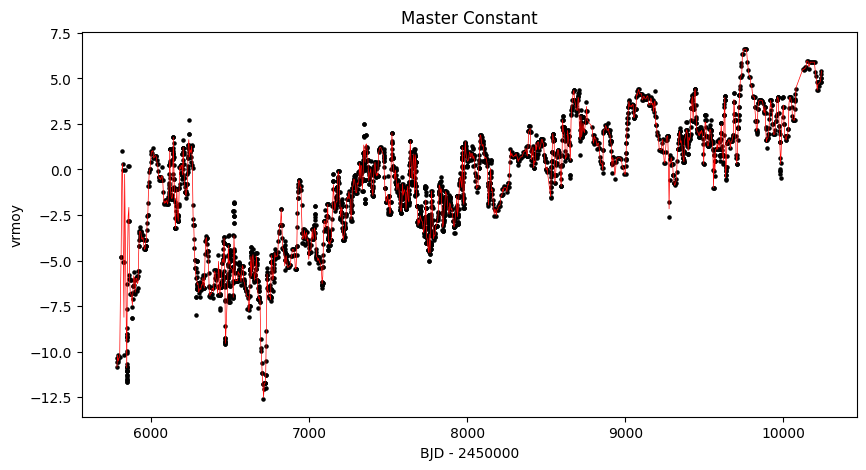

In [324]:
# Plot the master constant
plt.figure(figsize=(10, 5))
time = np.linspace(master['date'].min(), master['date'].max(), 1000)
plt.plot(time, f(time), color='red', lw=0.5)
plt.scatter(master['date'], master['vrmoy'], c='k', s=5)
plt.xlabel('BJD - 2450000')
plt.ylabel('vrmoy')
plt.title('Master Constant')
plt.savefig('drive/MyDrive/Doctorado/Sophie_ML/master-constant.png', dpi=200)
plt.show()

In [325]:
# Apply the interpolation function to the BJD values of HD185144
bjd_mask = train_data['HD185144']['bjd'] < master['date'].max()
hd185144_vrmoy = f(train_data['HD185144']['bjd'][bjd_mask])

# Subtract the interpolated vrmoy from the ccf_rv
hd185144_corrected = train_data['HD185144']['ccf_rv'][bjd_mask] - hd185144_vrmoy

### Fit a 3D polynommial

In [326]:
# Import the necessary library
from numpy.polynomial import Polynomial

# Fit a 3-degree polynomial to the corrected data
coeffs = Polynomial.fit(train_data['HD185144']['bjd'][bjd_mask], hd185144_corrected-hd185144_corrected.median(), deg=3)

# Print the coefficients of the polynomial
print(coeffs)

0.19932194 + 1.06777577·x - 0.40819543·x² - 0.14803525·x³


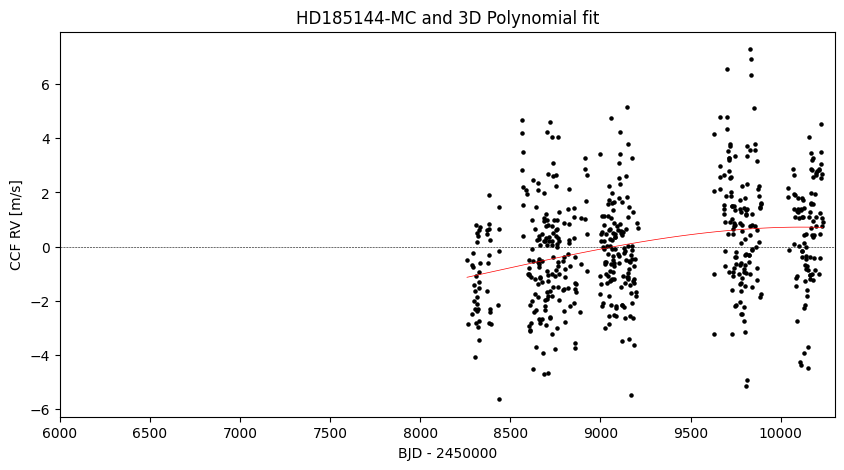

In [327]:
# Generate x values for the polynomial
x_vals = np.linspace(train_data['HD185144']['bjd'][bjd_mask].min(), train_data['HD185144']['bjd'][bjd_mask].max(), 100)

# Calculate the y values for the polynomial
y_vals = coeffs(x_vals)

# Plot the corrected data and the polynomial
plt.figure(figsize=(10, 5))
plt.scatter(train_data['HD185144']['bjd'][bjd_mask], hd185144_corrected-hd185144_corrected.median(), c='k', s=5)
plt.plot(x_vals, y_vals, color='red', lw=0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=0.4)
plt.xlabel('BJD - 2450000')
plt.xlim(6000, 10300)
plt.ylabel('CCF RV [m/s]')
plt.title('HD185144-MC and 3D Polynomial fit')
plt.savefig('drive/MyDrive/Doctorado/Sophie_ML/hd185144-polynomial.png', dpi=200)
plt.show()

In [328]:
# calcular la correccion para toda la serie
y_correction = coeffs(train_data['HD185144']['bjd'])

### Correct for activity

In [329]:
# Subtract the correction from the ccf_rv
train_data['HD185144']['ccf_rv'] = train_data['HD185144']['ccf_rv'] - y_correction

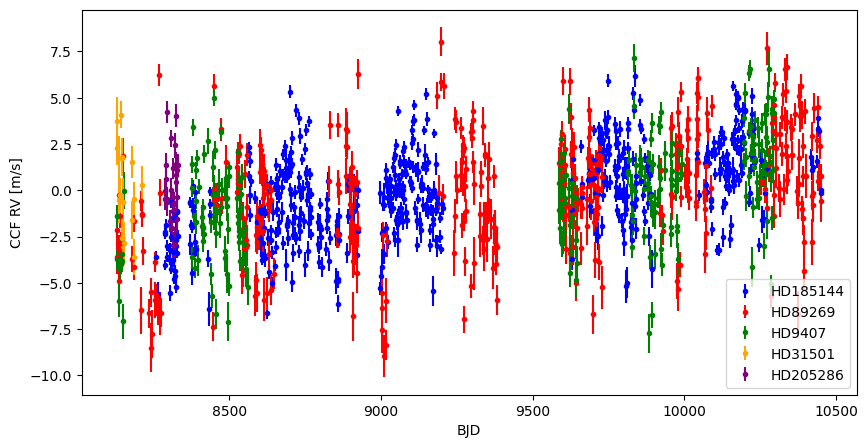

In [330]:
# plot the ccf_rv vs bjd for the 5 train stars with different colors and use errorbars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, star in enumerate(train_stars):
  ax.errorbar(train_data[star]['bjd'], (train_data[star]['ccf_rv']-train_data[star]['ccf_rv'].median()),
              train_data[star]['ccf_rv_error'], fmt='.', color=colors[i], label=star)
ax.set_xlabel('BJD')
ax.set_ylabel('CCF RV [m/s]')
plt.legend()
plt.show()

# Feature engineering

### Center the RVs

In [331]:
# for each star substract the median of ccf_rv
for star in train_stars:
  train_data[star]['ccf_rv'] = train_data[star]['ccf_rv'] - train_data[star]['ccf_rv'].median()

In [332]:
# how many points from each star we have?
for star in train_stars:
  print(star, len(train_data[star]))

HD185144 582
HD89269 387
HD9407 234
HD31501 16
HD205286 26


### Drop useless features and define Weights

In [333]:
print(train_data['HD185144'].columns)

Index(['file_ccf', 'target', 'ccf_rv', 'ccf_rv_error', 'ccf_fwhm',
       'ccf_contrast', 'ccf_span', 'berv', 'cal_ext_sn0', 'cal_ext_sn1',
       'cal_ext_sn2', 'cal_ext_sn3', 'cal_ext_sn4', 'cal_ext_sn5',
       'cal_ext_sn6', 'cal_ext_sn7', 'cal_ext_sn8', 'cal_ext_sn9',
       'cal_ext_sn10', 'cal_ext_sn11', 'cal_ext_sn12', 'cal_ext_sn13',
       'cal_ext_sn14', 'cal_ext_sn15', 'cal_ext_sn16', 'cal_ext_sn17',
       'cal_ext_sn18', 'cal_ext_sn19', 'cal_ext_sn20', 'cal_ext_sn21',
       'cal_ext_sn22', 'cal_ext_sn23', 'cal_ext_sn24', 'cal_ext_sn25',
       'cal_ext_sn26', 'cal_ext_sn27', 'cal_ext_sn28', 'cal_ext_sn29',
       'cal_ext_sn30', 'cal_ext_sn31', 'cal_ext_sn32', 'cal_ext_sn33',
       'cal_ext_sn34', 'cal_ext_sn35', 'cal_ext_sn36', 'cal_ext_sn37',
       'cal_ext_sn38', 'bjd', 'file_e2ds', 'modo', 'shutter_time',
       'ins_adcang', 'ins_adcnum', 'temp1_min', 'temp1_max', 'temp3_min',
       'temp3_max', 'pres1_min', 'pres1_max', 'pres2_min', 'pres2_max',
       'date_sta

In [334]:
# define the columns to drop and drop them
drop_columns = ['file_ccf','target','date_start','date_end','file_e2ds',
               'modo', 'targ_radvel', 'drift_nbcosmic',
               'DATE', 'mid_obs']
# drop_columns = ['file_ccf','target','date_start','date_end','file_e2ds',
#                'modo', 'targ_radvel', 'drift_rv', 'drift_rflux', 'drift_nbcosmic',
#                'DATE', 'mid_obs']

# save errors for weights before droping them
weights = {}
errors = {}
classes = len(train_stars)
samples = 0
for star in train_stars:
  samples += len(train_data[star])

for star in train_stars:
  errors[star] = train_data[star]['ccf_rv_error']
  # weights[star] = samples / (classes * len(train_data[star])) / (train_data[star]['ccf_rv_error'] ** 2)
  weights[star] = 1 / (train_data[star]['ccf_rv_error'])**2
  train_data[star].drop(columns=['ccf_rv_error'], inplace=True)

for star in train_stars:
  train_data[star].drop(columns=drop_columns, inplace=True)

### Temperature, airmass and pressure new features

In [335]:
# Iterate over the stars
for star in train_stars:
  # Calculate the average and difference for airmass
  train_data[star]['airm_avg'] = (train_data[star]['airm_start'] + train_data[star]['airm_end']) / 2
  train_data[star]['airm_diff'] = train_data[star]['airm_start'] - train_data[star]['airm_end']
  # Calculate the average and difference for temp1
  train_data[star]['temp1_avg'] = (train_data[star]['temp1_min'] + train_data[star]['temp1_max']) / 2
  train_data[star]['temp1_diff'] = train_data[star]['temp1_min'] - train_data[star]['temp1_max']
  # Calculate the average and difference for temp3
  train_data[star]['temp3_avg'] = (train_data[star]['temp3_min'] + train_data[star]['temp3_max']) / 2
  train_data[star]['temp3_diff'] = train_data[star]['temp3_min'] - train_data[star]['temp3_max']
  # Calculate the average and difference for pres1
  train_data[star]['pres1_avg'] = (train_data[star]['pres1_min'] + train_data[star]['pres1_max']) / 2
  train_data[star]['pres1_diff'] = train_data[star]['pres1_min'] - train_data[star]['pres1_max']
  # Calculate the average and difference for pres2
  train_data[star]['pres2_avg'] = (train_data[star]['pres2_min'] + train_data[star]['pres2_max']) / 2
  train_data[star]['pres2_diff'] = train_data[star]['pres2_min'] - train_data[star]['pres2_max']
  # Drop the original columns
  train_data[star].drop(columns=['airm_start', 'airm_end', 'temp1_min', 'temp1_max', 'temp3_min', 'temp3_max', 'pres1_min', 'pres1_max', 'pres2_min', 'pres2_max'], inplace=True)

In [336]:
# Check the number of NaN values for each star
for star in train_stars:
  print(f"Star: {star}")
  print(train_data[star].isna().sum().sum())

Star: HD185144
0
Star: HD89269
0
Star: HD9407
0
Star: HD31501
0
Star: HD205286
0


### New S/N combinations

In [337]:
# Combine all dataframes into one
all_data = pd.concat([train_data[star] for star in train_stars], ignore_index=True)

# Also combine the weights and errors
weight = pd.concat([weights[star] for star in train_stars], ignore_index=True)
error = pd.concat([errors[star] for star in train_stars], ignore_index=True)

# Calculate the Pearson correlation between 'cal_ext_sn' features and 'ccf_rv'
corr_matrix = all_data.corr()

# Get the correlation values for 'cal_ext_sn' features with 'ccf_rv'
cal_ext_sn_corr = corr_matrix['ccf_rv'][corr_matrix.columns.str.startswith('cal_ext_sn')]

# Create a list to store the results
results = []

# Iterate over all pairs of 'cal_ext_sn' features
for i in range(len(cal_ext_sn_corr.index)):
  for j in range(i + 1, len(cal_ext_sn_corr.index)):
    feature1 = cal_ext_sn_corr.index[i]
    feature2 = cal_ext_sn_corr.index[j]

    # Calculate the ratio and subtraction
    all_data[f'{feature1}_div_{feature2}'] = all_data[feature1] / all_data[feature2]
    all_data[f'{feature1}_sub_{feature2}'] = all_data[feature1] - all_data[feature2]

    # Calculate the correlation with 'ccf_rv' for the new features
    corr_ratio = all_data[f'{feature1}_div_{feature2}'].corr(all_data['ccf_rv'])
    corr_sub = all_data[f'{feature1}_sub_{feature2}'].corr(all_data['ccf_rv'])

    # Store the results
    results.append({
        'feature1': feature1,
        'feature2': feature2,
        'ratio_corr': corr_ratio,
        'sub_corr': corr_sub
    })

# Sort the results by the absolute value of the correlation
results.sort(key=lambda x: max(abs(x['ratio_corr']), abs(x['sub_corr'])), reverse=True)

# Select the top 100 features
top_100_results = results[:100]

In [338]:
# create a list of selected features, append the first combination of top_100_results, only sub or ratio, the one with most correlation
selected_features = []
if abs(results[0]['ratio_corr']) > abs(results[0]['sub_corr']):
  selected_features.append(f"{results[0]['feature1']}_div_{results[0]['feature2']}")
else:
  selected_features.append(f"{results[0]['feature1']}_sub_{results[0]['feature2']}")

In [339]:
# Iterate over the remaining results
for i in range(1, len(results)):
  result = results[i]

  # Determine the most correlated feature
  if abs(result['ratio_corr']) > abs(result['sub_corr']):
    rvcorr = result['ratio_corr']
    new_feature = f"{result['feature1']}_div_{result['feature2']}"
  else:
    rvcorr = result['sub_corr']
    new_feature = f"{result['feature1']}_sub_{result['feature2']}"

  # Check if the new feature is correlated with the previous selected features
  is_correlated = False
  for feature in selected_features:
    corr = all_data[new_feature].corr(all_data[feature])
    if abs(corr) > 0.7:
      is_correlated = True
      break

  # If not correlated, add it to the selected features
  if not is_correlated:
    if np.abs(rvcorr) > 0.5:
      selected_features.append(new_feature)

In [340]:
# Create a dictionary to store the selected features and their correlation with 'ccf_rv'
feature_corr = {}
for feature in selected_features:
  corr = all_data[feature].corr(all_data['ccf_rv'])
  feature_corr[feature] = corr

# Sort the features by correlation in descending order
sorted_features = sorted(feature_corr.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the selected features and their correlation with 'ccf_rv'
for feature, corr in sorted_features:
  print(f"Feature: {feature}, Correlation with ccf_rv: {corr:.4f}")

Feature: cal_ext_sn7_sub_cal_ext_sn8, Correlation with ccf_rv: 0.3215


In [341]:
selected_features[0].split('_')

['cal', 'ext', 'sn7', 'sub', 'cal', 'ext', 'sn8']

In [342]:
# delete the all_data dataframe to save memory
del all_data

In [343]:
# Split the selected features into a list of feature1, feature2, and operation
selected_features_split = []
for feature in selected_features:
  parts = feature.split('_')
  feature1 = parts[2]
  feature2 = parts[6]
  operation = parts[3]
  selected_features_split.append((feature1, feature2, operation))

# Iterate over the stars
for star in train_stars:
  # Calculate the new columns for each star
  for feature1, feature2, operation in selected_features_split:
    if operation == 'div':
      train_data[star][f'{feature1}_div_{feature2}'] = train_data[star]['cal_ext_'+feature1] / train_data[star]['cal_ext_'+feature2]
    elif operation == 'sub':
      train_data[star][f'{feature1}_sub_{feature2}'] = train_data[star]['cal_ext_'+feature1] - train_data[star]['cal_ext_'+feature2]

In [344]:
train_data['HD185144'].columns

Index(['ccf_rv', 'ccf_fwhm', 'ccf_contrast', 'ccf_span', 'berv', 'cal_ext_sn0',
       'cal_ext_sn1', 'cal_ext_sn2', 'cal_ext_sn3', 'cal_ext_sn4',
       'cal_ext_sn5', 'cal_ext_sn6', 'cal_ext_sn7', 'cal_ext_sn8',
       'cal_ext_sn9', 'cal_ext_sn10', 'cal_ext_sn11', 'cal_ext_sn12',
       'cal_ext_sn13', 'cal_ext_sn14', 'cal_ext_sn15', 'cal_ext_sn16',
       'cal_ext_sn17', 'cal_ext_sn18', 'cal_ext_sn19', 'cal_ext_sn20',
       'cal_ext_sn21', 'cal_ext_sn22', 'cal_ext_sn23', 'cal_ext_sn24',
       'cal_ext_sn25', 'cal_ext_sn26', 'cal_ext_sn27', 'cal_ext_sn28',
       'cal_ext_sn29', 'cal_ext_sn30', 'cal_ext_sn31', 'cal_ext_sn32',
       'cal_ext_sn33', 'cal_ext_sn34', 'cal_ext_sn35', 'cal_ext_sn36',
       'cal_ext_sn37', 'cal_ext_sn38', 'bjd', 'shutter_time', 'ins_adcang',
       'ins_adcnum', 'tel_alt', 'guid_seeing', 'guid_sky_level', 'guid_alpha',
       'guid_alpha_rms', 'guid_delta', 'guid_delta_rms', 'targ_alpha',
       'targ_delta', 'drift_rv', 'drift_rflux', 'conteneur', 'gr

### Stellar features

In [345]:
# HD 185144
TEFF_HD185144 = 	5153
# LOGG = 4.501
# FE/H = -0.407

# HD 89269
TEFF_HD89269 = 	5581
# LOGG = 4.415
# FE/H = 	-0.133

# HD 9407
TEFF_HD9407 = 	5541
# LOGG =  4.378
# FE/H = 	-0.259

# HD205286
TEFF_205286 = 5320.4
# LOGG = 4.4481
# FE/H = 0.1481

# HD31501
TEFF_31501 = 5401

# map the teffs to the stars
teffs = {'HD185144': TEFF_HD185144,
         'HD89269': TEFF_HD89269,
         'HD9407': TEFF_HD9407,
         'HD205286': TEFF_205286,
         'HD31501': TEFF_31501}

# Add the 'teff' column with the specified values for each star
for star in train_stars:
  train_data[star]['teff'] = teffs[star]

### Target distribution

# Explore Correlations and Select Features

In [346]:
# how many features we have?
all_dfs = pd.concat([train_data[star] for star in train_stars], ignore_index=True)

# Get the number of features
num_features = len(all_dfs.columns)
print(f"Number of features: {num_features}")

Number of features: 84


### Target variable distribution

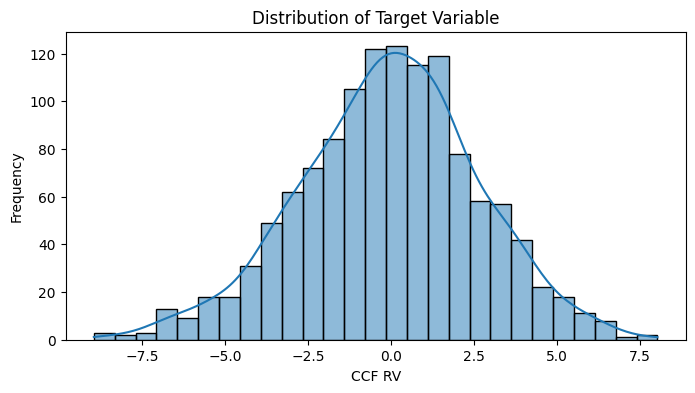

In [347]:
# Plot the distribution of the target variable
plt.figure(figsize=(8, 4))
sns.histplot(all_dfs['ccf_rv'], kde=True)
plt.xlabel('CCF RV')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

In [348]:
all_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 84 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ccf_rv          1245 non-null   float64
 1   ccf_fwhm        1245 non-null   float64
 2   ccf_contrast    1245 non-null   float64
 3   ccf_span        1245 non-null   float64
 4   berv            1245 non-null   float64
 5   cal_ext_sn0     1245 non-null   float64
 6   cal_ext_sn1     1245 non-null   float64
 7   cal_ext_sn2     1245 non-null   float64
 8   cal_ext_sn3     1245 non-null   float64
 9   cal_ext_sn4     1245 non-null   float64
 10  cal_ext_sn5     1245 non-null   float64
 11  cal_ext_sn6     1245 non-null   float64
 12  cal_ext_sn7     1245 non-null   float64
 13  cal_ext_sn8     1245 non-null   float64
 14  cal_ext_sn9     1245 non-null   float64
 15  cal_ext_sn10    1245 non-null   float64
 16  cal_ext_sn11    1245 non-null   float64
 17  cal_ext_sn12    1245 non-null   f

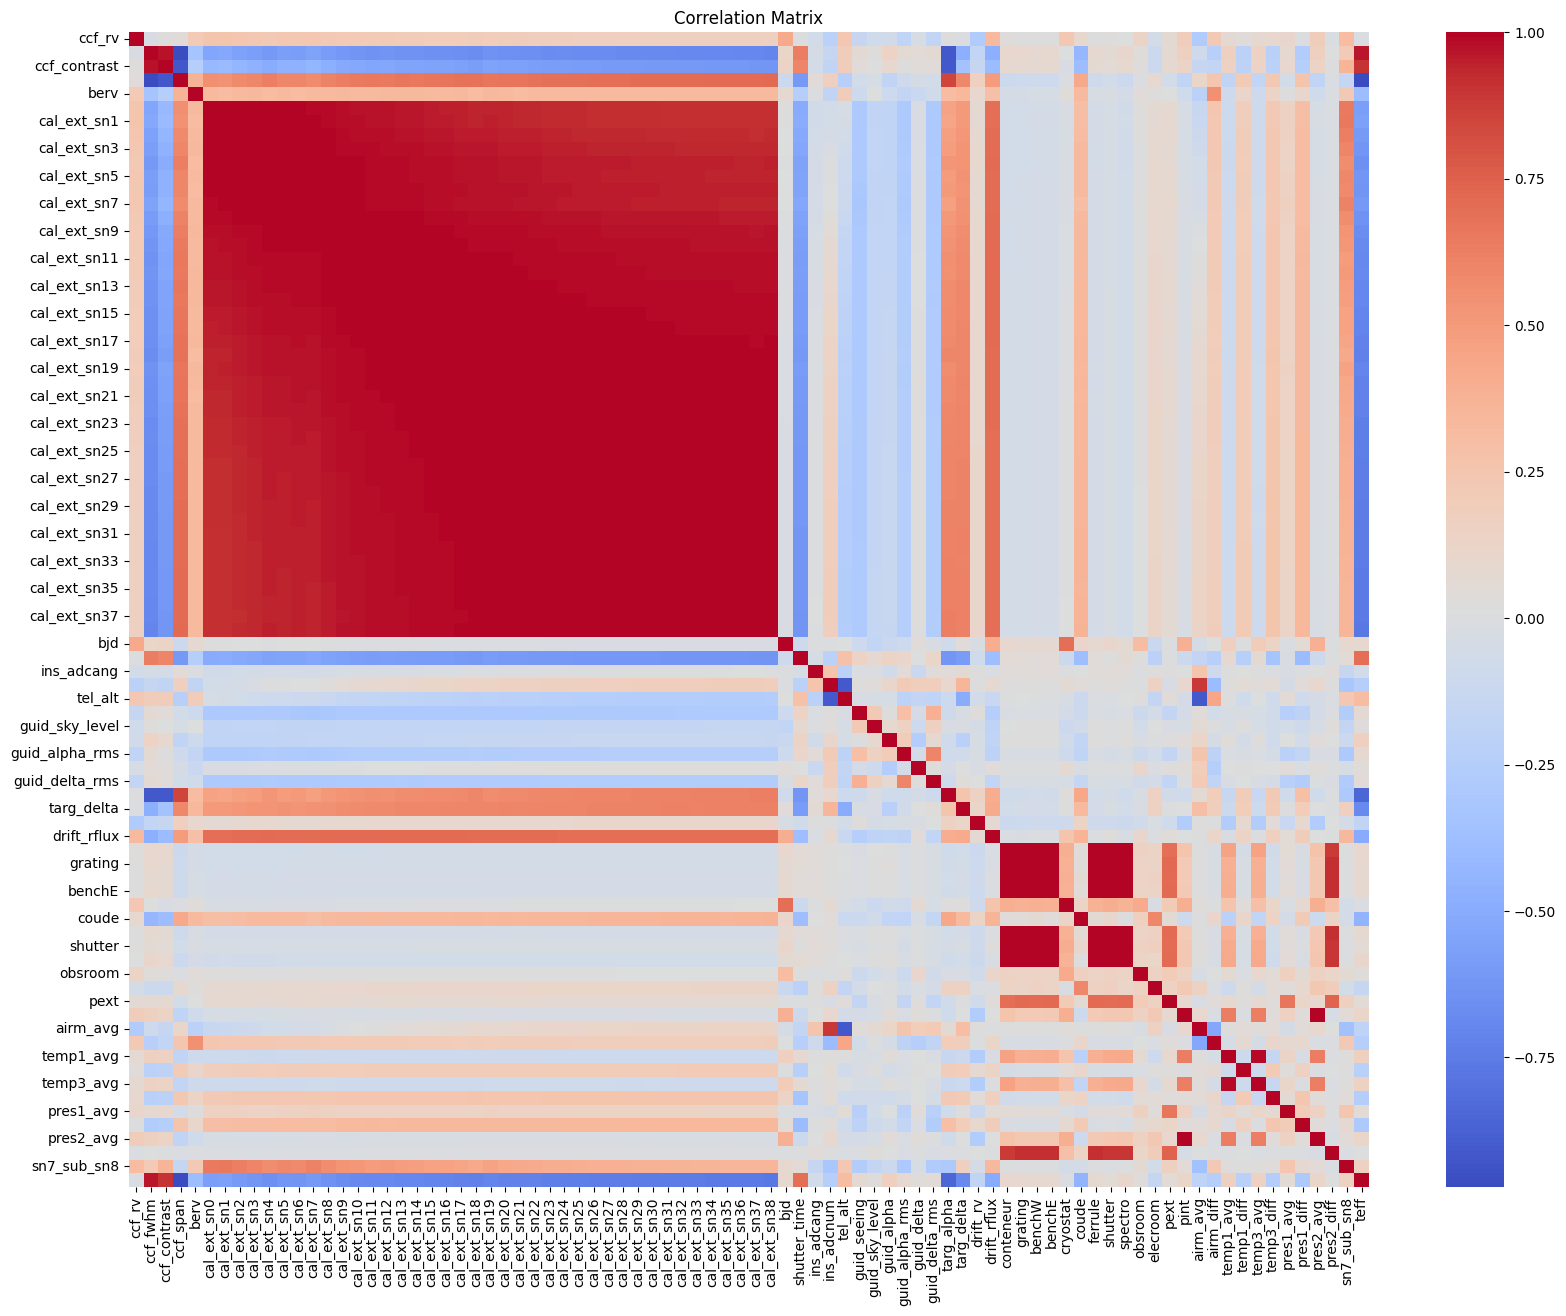

In [349]:
# Calculate the correlation matrix
corr_matrix = all_dfs.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

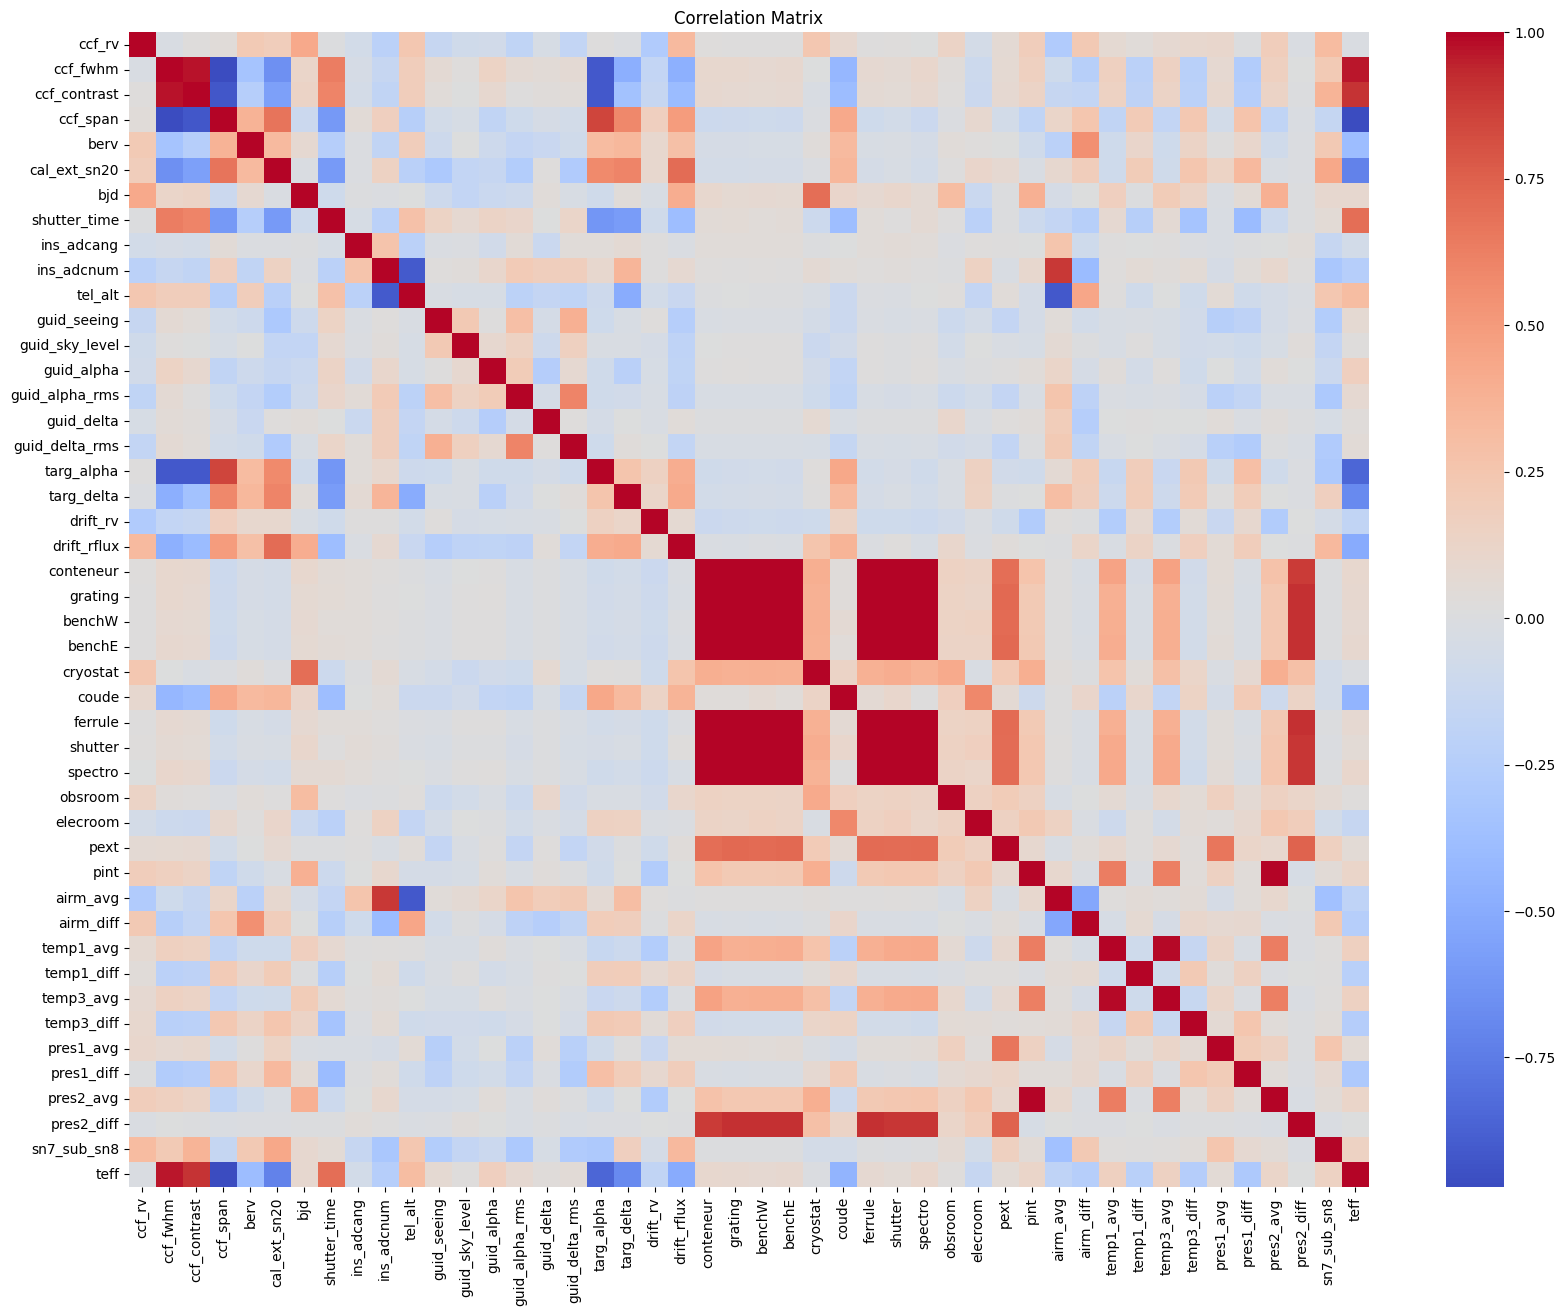

In [350]:
# Select only the 'cal_ext_sn20' feature from the 'cal_ext_sn' features
cal_ext_sn_features = [col for col in all_dfs.columns if col.startswith('cal_ext_sn') and col != 'cal_ext_sn20']

# Drop the selected features
all_dfs = all_dfs.drop(columns=cal_ext_sn_features)

# Calculate the correlation matrix
corr_matrix = all_dfs.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [351]:
# save the target feature ccf_rv
target = all_dfs['ccf_rv']

# drop it from the dataset
all_dfs = all_dfs.drop(columns=['ccf_rv'])

In [352]:
sensors = ['conteneur', 'grating', 'benchW', 'benchE', 'ferrule', 'shutter', 'spectro']

In [353]:
# Calculate the correlation between 'ccf_rv' and the 'sensors' features
corr_sensors = {}
for sensor in sensors:
  corr = all_dfs[sensor].corr(target)
  corr_sensors[sensor] = corr

# Find the sensor with the highest correlation
max_corr_sensor = max(corr_sensors, key=corr_sensors.get)
print(f"Sensor with the highest correlation: {max_corr_sensor}")

# Keep only the sensor with the highest correlation
sensors_to_keep = [max_corr_sensor]

# Drop the other 'sensors' features
all_dfs = all_dfs.drop(columns=[col for col in sensors if col != max_corr_sensor])

Sensor with the highest correlation: conteneur


In [354]:
ccfs = ['ccf_span', 'ccf_contrast', 'ccf_fwhm']

In [355]:
# Calculate the correlation between 'ccf_rv' and the 'ccfs' features
corr_ccfs = {}
for ccf in ccfs:
  corr = all_dfs[ccf].corr(target)
  corr_ccfs[ccf] = corr

# Find the ccf with the highest correlation
max_corr_ccf = max(corr_ccfs, key=corr_ccfs.get)
print(f"ccf with the highest correlation: {max_corr_ccf}")

# Keep only the ccf with the highest correlation
ccfs_to_keep = [max_corr_ccf]

# Drop the other 'ccfs' features
all_dfs = all_dfs.drop(columns=[col for col in ccfs if col != max_corr_ccf])

ccf with the highest correlation: ccf_span


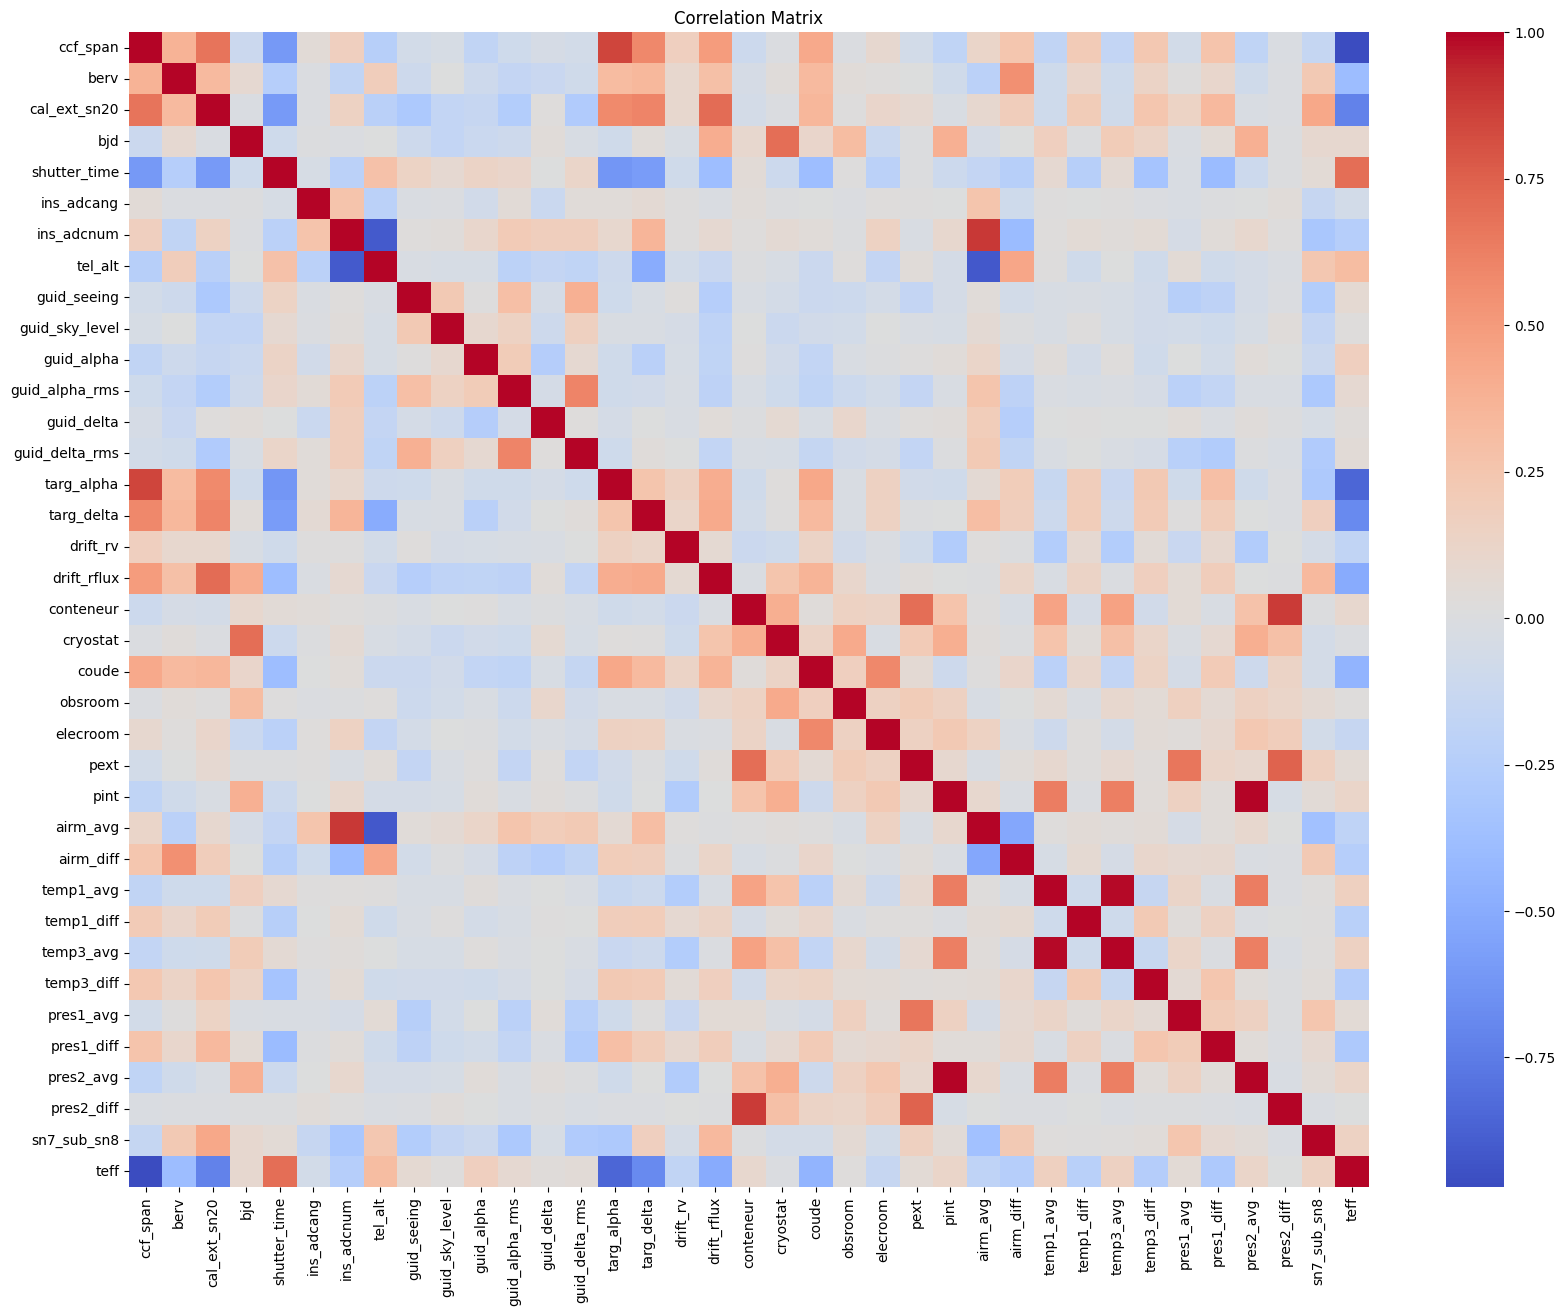

In [356]:
# Calculate the correlation matrix
corr_matrix = all_dfs.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Correlation with target variable

In [357]:
corr_target = all_dfs.corrwith(target)
print(corr_target.sort_values(ascending=False))

bjd               0.426733
drift_rflux       0.330065
sn7_sub_sn8       0.321471
cryostat          0.244089
tel_alt           0.239350
airm_diff         0.222894
berv              0.214704
cal_ext_sn20      0.187804
pres2_avg         0.186060
pint              0.186027
obsroom           0.131504
pres1_avg         0.105410
temp3_diff        0.097766
coude             0.089505
temp3_avg         0.080581
temp1_avg         0.069690
pext              0.061713
ccf_span          0.044450
temp1_diff        0.043601
conteneur         0.025359
targ_alpha        0.017506
shutter_time      0.006428
pres1_diff        0.003129
targ_delta       -0.008318
teff             -0.012184
pres2_diff       -0.014020
guid_delta       -0.033431
elecroom         -0.062316
ins_adcang       -0.066287
guid_alpha       -0.072115
guid_sky_level   -0.080774
guid_seeing      -0.145880
guid_delta_rms   -0.169430
guid_alpha_rms   -0.178434
ins_adcnum       -0.210366
drift_rv         -0.274256
airm_avg         -0.274386
d

### **Final datasets**

In [358]:
# MINIMAL SELECTION
# teff: because it's correlated with many other
# airm_avg: highly correlated with tel_alt, which has more correlation with target
# pint: it's almost the same feature as pres2_avg
# temp1_avg: high correlation with temp3_avg
# targ_alpha and targ_delta: correlation with others, no corr with target
# ccf_span: high corr with ccf_fwhm
# ins_adcnum: high correlation with tel_alt
# berv and bjd: because we don't use time as variable
# drift rv and drift_rflux: because we can't use them
minimal_columns = ['teff', 'airm_avg', 'pint', 'berv', 'bjd', 'temp1_avg',
                   'targ_alpha', 'targ_delta', 'ccf_span', 'ins_adcnum',
                   'drift_rv', 'drift_rflux']

# COMPLETE SELECTION
# drift rv and drift_rflux: because we can't use them
complete_columns = ['drift_rv', 'drift_rflux']

#complete = all_dfs.drop(columns=complete_columns)
complete = all_dfs.copy()

# Drop the specified columns
minimal = all_dfs.drop(columns=minimal_columns)
print('complete columns:', len(complete.columns))
print('minimal columns:', len(minimal.columns))

complete columns: 37
minimal columns: 25


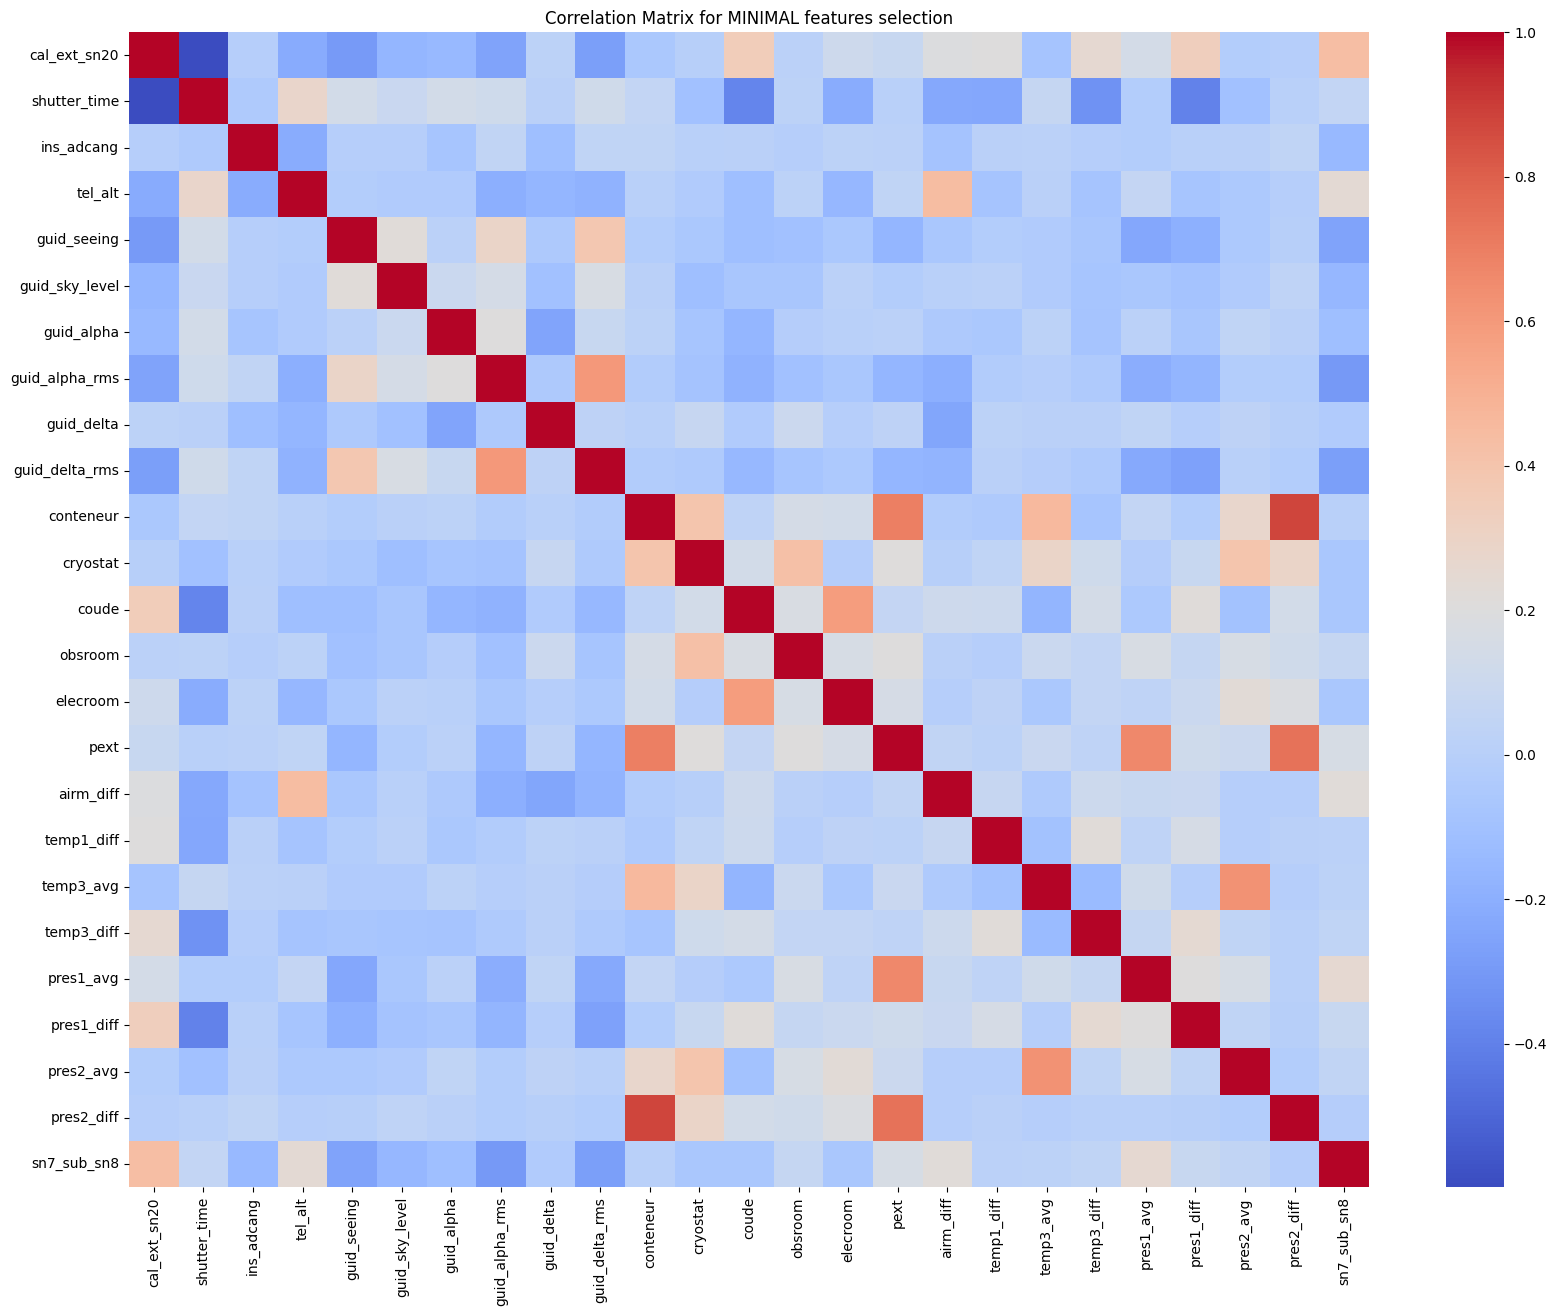

In [359]:
# Calculate the correlation matrix
corr_matrix = minimal.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for MINIMAL features selection')
plt.show()

### ViF

In [360]:
# calculate the Variance Inflation Factor for all the features
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = all_dfs.columns
vif_data["VIF"] = [variance_inflation_factor(all_dfs.values, i) for i in range(len(all_dfs.columns))]

print(vif_data.sort_values(by='VIF', ascending=False))

           feature           VIF
24            pint  6.058926e+11
33       pres2_avg  6.058111e+11
29       temp3_avg  2.147169e+07
18       conteneur  1.910325e+07
31       pres1_avg  1.633339e+07
23            pext  1.630926e+07
27       temp1_avg  5.824015e+06
36            teff  9.038219e+04
19        cryostat  5.378244e+03
22        elecroom  1.568674e+03
25        airm_avg  9.991895e+02
20           coude  9.910286e+02
21         obsroom  7.442091e+02
3              bjd  6.296539e+02
7          tel_alt  4.775612e+02
15      targ_delta  4.510488e+02
34      pres2_diff  1.312365e+02
2     cal_ext_sn20  1.062316e+02
14      targ_alpha  1.027215e+02
35     sn7_sub_sn8  8.393417e+01
0         ccf_span  8.276144e+01
6       ins_adcnum  7.595281e+01
17     drift_rflux  6.646865e+01
4     shutter_time  2.075962e+01
13  guid_delta_rms  1.369873e+01
11  guid_alpha_rms  1.017474e+01
9   guid_sky_level  7.879455e+00
8      guid_seeing  6.422028e+00
5       ins_adcang  4.320362e+00
30      te

### Heavy Tail features

In [361]:
# Calculate kurtosis and skewness for all features
kurtosis_values = all_dfs.kurtosis()
skewness_values = all_dfs.skew()

# Combine kurtosis and skewness into a DataFrame
stats_df = pd.DataFrame({'Kurtosis': kurtosis_values, 'Skewness': skewness_values})

# Sort by skewness in descending order
stats_df = stats_df.sort_values(by=['Skewness'], ascending=False)

# Print the results
print(stats_df)

                   Kurtosis   Skewness
temp3_avg        209.652022  13.832567
temp1_avg        196.867798  13.651198
guid_alpha        98.876286   4.553212
guid_alpha_rms    34.193751   3.724908
drift_rv          85.421318   3.542776
guid_delta_rms    23.822262   3.236962
pint              38.035379   3.099816
pres2_avg         37.989163   3.095496
airm_avg           4.940518   1.679855
shutter_time       6.009468   1.668414
guid_seeing        7.110050   1.311715
drift_rflux        2.647633   1.302412
cal_ext_sn20      -0.865401   0.485521
elecroom           2.770844   0.449280
tel_alt            0.219621   0.413389
coude              1.547282   0.388359
ins_adcnum         0.219136   0.307754
ccf_span          -1.886168  -0.007598
bjd               -1.377695  -0.043752
teff              -1.951124  -0.045028
guid_sky_level    -0.494597  -0.048976
sn7_sub_sn8        0.916149  -0.111375
ins_adcang        -1.424870  -0.223201
pres1_avg          0.897501  -0.278043
berv              -0.4292

In [362]:
# Save the feature names with absolute value of skew > 10
heavy_tail_features = stats_df[abs(stats_df['Skewness']) > 10].index.tolist()
print(heavy_tail_features)

['temp3_avg', 'temp1_avg', 'guid_delta', 'pext', 'conteneur', 'pres2_diff']


In [363]:
# fig, axes = plt.subplots(nrows=1, ncols=len(heavy_tail_features), figsize=(20, 5))

# # Iterate over the heavy_tail_features and plot histograms
# for i, feature in enumerate(heavy_tail_features):
#   sns.histplot(all_dfs[feature], kde=True, ax=axes[i])
#   axes[i].set_xlabel(feature)
#   axes[i].set_ylabel('Frequency')
#   axes[i].set_title(f'Distribution of {feature}')
# plt.tight_layout()
# plt.show()

# **Modeling**

## **Train-Test Split**

In [364]:
complete.columns

Index(['ccf_span', 'berv', 'cal_ext_sn20', 'bjd', 'shutter_time', 'ins_adcang',
       'ins_adcnum', 'tel_alt', 'guid_seeing', 'guid_sky_level', 'guid_alpha',
       'guid_alpha_rms', 'guid_delta', 'guid_delta_rms', 'targ_alpha',
       'targ_delta', 'drift_rv', 'drift_rflux', 'conteneur', 'cryostat',
       'coude', 'obsroom', 'elecroom', 'pext', 'pint', 'airm_avg', 'airm_diff',
       'temp1_avg', 'temp1_diff', 'temp3_avg', 'temp3_diff', 'pres1_avg',
       'pres1_diff', 'pres2_avg', 'pres2_diff', 'sn7_sub_sn8', 'teff'],
      dtype='object')

**Weights:**

$w = n_{samples}/(n_{classes} * c_{count}) \frac{1}{\sigma^2}$

or

$w = \frac{1}{\sigma^2}$

In [365]:
# split: 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

use = complete
#use = minimal

# Split the data into train and test sets stratified by the star (teff)
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(use, target, weight, test_size=0.2, stratify=complete['teff'], random_state=42)
teff_train, teff_test = train_test_split(complete['teff'], test_size=0.2, stratify=complete['teff'], random_state=42)
bjd_train, bjd_test = train_test_split(all_dfs['bjd'], test_size=0.2, stratify=complete['teff'], random_state=42)

In [366]:
print('training points:', len(x_train))
print('testing points:', len(x_test))
print('weight training points', len(w_train))
print('weight testing points', len(w_test))

training points: 996
testing points: 249
weight training points 996
weight testing points 249


## **Transformation and Scaling**

In [367]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler(feature_range=(-1,1))

scaler = std_scaler

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## XGBoost

In [368]:
from sklearn.metrics import mean_squared_error, r2_score

def train_model(model, params):
    """
    Fits the given model with the specified parameters and prints the results in a structured format.

    Args:
        model: The model to be trained.
        params: A dictionary of parameters for the model.
    """
    # Set model parameters and fit the model
    if params is None:
      params = {'random_state': 42}
    model.set_params(**params)
    model.fit(x_train, y_train, sample_weight=w_train)

    # Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics for training data
    wrmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred, sample_weight=w_train))
    r2_train = r2_score(y_train, y_train_pred, sample_weight=w_train)

    # Calculate metrics for testing data
    wrmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred, sample_weight=w_test))
    r2_test = r2_score(y_test, y_test_pred, sample_weight=w_test)

    # Display results
    print("\n======================== Model Results ========================")
    print("Training Set Metrics:")
    print(f"{'WRMSE Train:':<20} {wrmse_train:.4f}")
    print(f"{'R² Train:':<20} {r2_train:.4f}")

    print("\nTesting Set Metrics:")
    print(f"{'WRMSE Test:':<20} {wrmse_test:.4f}")
    print(f"{'R² Test:':<20} {r2_test:.4f}")

    # Display target dispersion (std of target)
    target_dispersion = y_train.std()
    print("\nAdditional Information:")
    print(f"{'Target Dispersion:':<20} {target_dispersion:.4f}")
    print("===============================================================\n")
    return model, y_train_pred, y_test_pred

In [369]:
from xgboost import XGBRegressor
import xgboost as xgb

In [370]:
# final set of params from fine tuning
params = {
    'n_estimators': 61,
    'learning_rate': 0.1,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.26,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.06,
    'reg_lambda': 1.15
}

# Create an XGBoost regressor
model = XGBRegressor(**params) # fine tuned params
#model = XGBRegressor()

trained_model, y_train_pred, y_test_pred = train_model(model, None)


======================== Model Results ========================
Training Set Metrics:
WRMSE Train:         1.0276
R² Train:            0.8200

Testing Set Metrics:
WRMSE Test:          1.6142
R² Test:             0.5261

Additional Information:
Target Dispersion:   2.6977



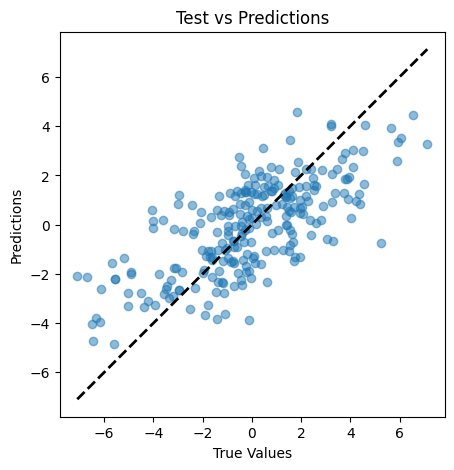

In [127]:
# Plot the test vs predictions
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(y_test, y_test_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')
ax.set_title('Test vs Predictions')
ax.set_aspect('equal')
plt.savefig('drive/MyDrive/Doctorado/Sophie_ML/test_vs_predictions.png', dpi=200)
plt.show()

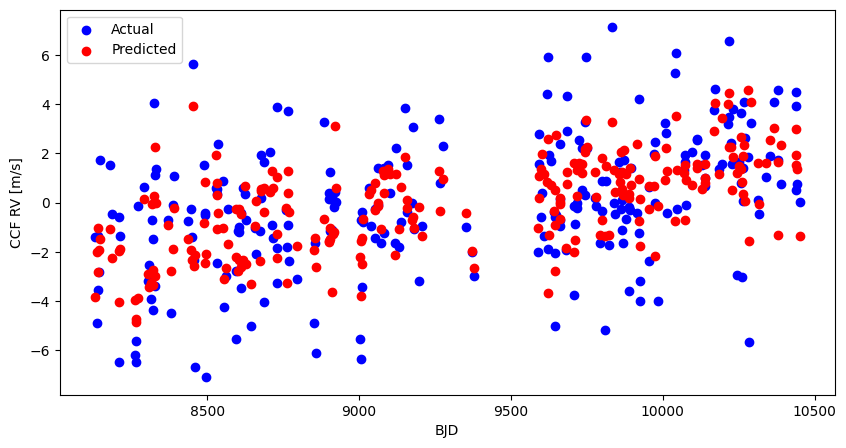

In [128]:
# Plot the predictions against the actual values
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(bjd_test, y_test, color='blue', label='Actual')
ax.scatter(bjd_test, y_test_pred, color='red', label='Predicted')
#ax.scatter(bjd_train, y_train, color='green', label='Train')
#ax.scatter(bjd_train, y_train_pred, color='yellow', label='Train Predicted')
ax.set_xlabel('BJD')
ax.set_ylabel('CCF RV [m/s]')
plt.legend()
plt.show()


           Feature  Importance
3              bjd    0.144833
16        drift_rv    0.071369
17     drift_rflux    0.059033
34      pres2_diff    0.050774
25        airm_avg    0.046002
18       conteneur    0.042886
24            pint    0.034146
13  guid_delta_rms    0.034130
29       temp3_avg    0.028611
2     cal_ext_sn20    0.027228
35     sn7_sub_sn8    0.026912
1             berv    0.026316
21         obsroom    0.025547
31       pres1_avg    0.024544
33       pres2_avg    0.024185
7          tel_alt    0.024063
27       temp1_avg    0.022023
20           coude    0.021365
15      targ_delta    0.020671
12      guid_delta    0.018817
19        cryostat    0.018380
30      temp3_diff    0.018303
8      guid_seeing    0.017861
26       airm_diff    0.016719
23            pext    0.016175
9   guid_sky_level    0.015261
4     shutter_time    0.014973
5       ins_adcang    0.014762
22        elecroom    0.014665
0         ccf_span    0.014520
32      pres1_diff    0.014414
10      

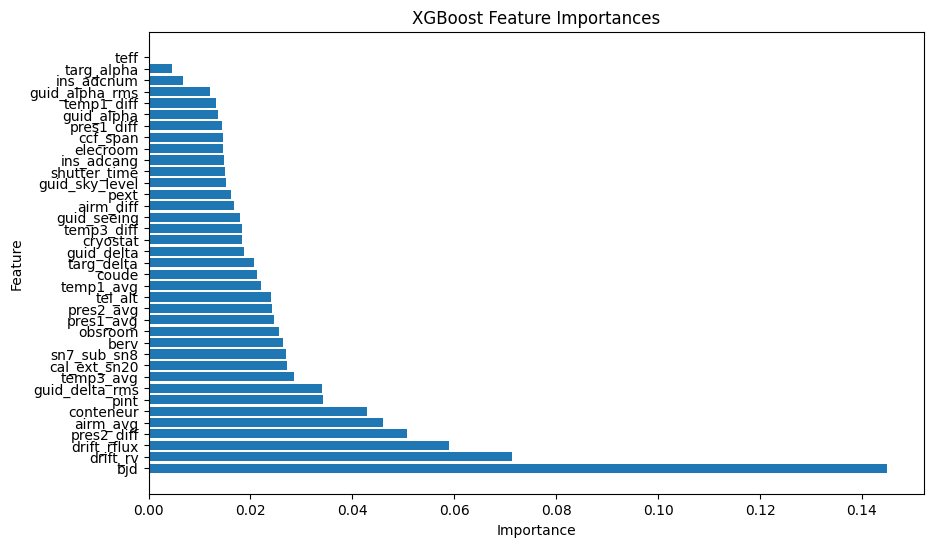

In [129]:
feature_importances = trained_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': use.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances')
plt.show()

In [708]:
# lets use early stopping to stop overfit
# Create an XGBoost regressor
model = XGBRegressor(**params, early_stopping_rounds=5) # fine tuned params
# Train the model
model.fit(x_train, y_train, sample_weight = w_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.26, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=61, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Estimators: 46


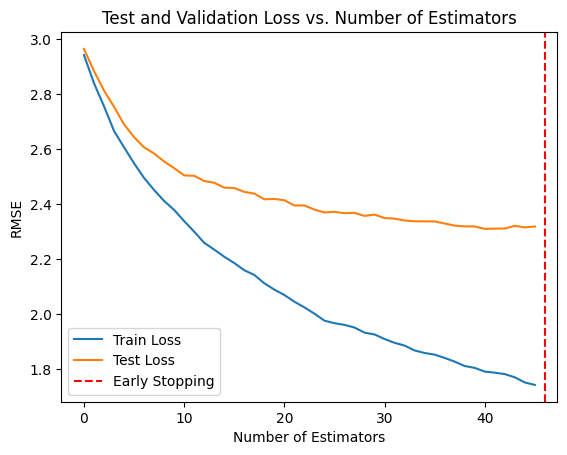

In [121]:
# Get the evaluation results from the model
results = model.evals_result()
estimators = len(results['validation_0']['rmse'])
print('Estimators:', estimators)
# Extract the test and validation loss
train_loss = results['validation_0']['rmse']
test_loss = results['validation_1']['rmse']  # Assuming you have a validation set

# Plot the loss curves
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
# show the early stopping estimators number
plt.axvline(x=estimators, color='r', linestyle='--', label='Early Stopping')
# write the number of estimators
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('Test and Validation Loss vs. Number of Estimators')
plt.legend()
plt.show()

#### Fine Tuning XGB

However, using early stopping during cross validation may not be a perfect approach because it changes the model’s number of trees for each validation fold, leading to different model. A better approach is to retrain the model after cross validation using the best hyperparameters along with early stopping. (from https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html)

**approach:** use GridsearchCV with XGBRegressor() to find best parameters, then fit a model with best parameters and use early stopping with test set to prevent overfitting. I followed: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [122]:
# Define learning rate, and use xgb.cv to find the number of estimators for that learning rate
params = {
    'learning_rate': 0.2
}

dtrain = xgb.DMatrix(x_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(x_test, label=y_test, weight=w_test)

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=7,
                    early_stopping_rounds=7, num_boost_round=500, metrics='rmse', seed=42,
                    as_pandas=True)

best_rmse = cv_results['test-rmse-mean'].tail().values[-1]
best_num_estimators = len(cv_results)

print("Best RMSE:", best_rmse)
print("Best Number of Estimators:", best_num_estimators)

Best RMSE: 2.0336065439148405
Best Number of Estimators: 31


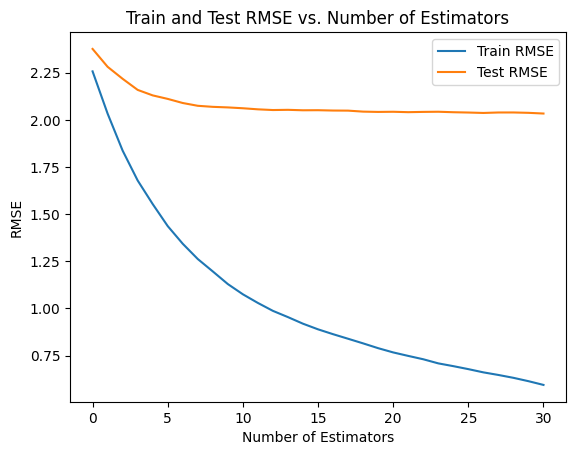

In [123]:
# Plot train-rmse and test-rmse as a function of estimators
plt.plot(cv_results['train-rmse-mean'], label='Train RMSE')
plt.plot(cv_results['test-rmse-mean'], label='Test RMSE')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE vs. Number of Estimators')
plt.legend()
plt.show()

In [ ]:
# Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree)
# for the decided learning rate and the number of trees.
# default parameters: https://xgboost.readthedocs.io/en/release_1.7.0/parameter.html

In [124]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_test1 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=32,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test1 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'max_depth': 3, 'min_child_weight': 3}
Best score: 2.3237534048355335


In [ ]:
# re-optimize number of estimators
params = {
    'learning_rate': 0.2,
    'max_depth': 4,
    'min_child_weight': 2
}

dtrain = xgb.DMatrix(x_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(x_test, label=y_test, weight=w_test)

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=7,
                    early_stopping_rounds=7, num_boost_round=500, metrics='rmse', seed=42,
                    as_pandas=True)

best_rmse = cv_results['test-rmse-mean'].tail().values[-1]
best_num_estimators = len(cv_results)

print("Best RMSE:", best_rmse)
print("Best Number of Estimators:", best_num_estimators)

Best RMSE: 1.7604789728843966
Best Number of Estimators: 23


In [ ]:
# tune gamma

In [ ]:
# Define the parameter grid
param_test2 = {
 'gamma':[i/10.0 for i in range(0,9)]
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=28,
                     max_depth=4, min_child_weight=2,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test2 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'gamma': 0.2}
Best score: 2.0573223761879773


In [ ]:
# Define a finer grid on gamma
param_test2 = {
 'gamma': np.arange(0.12, 0.29, 0.02)
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=28,
                     max_depth=4, min_child_weight=1,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test2 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'gamma': 0.2599999999999999}
Best score: 2.073951477300923


In [ ]:
# re-optimize number of estimators
params = {
    'learning_rate': 0.2,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.26
}

dtrain = xgb.DMatrix(x_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(x_test, label=y_test, weight=w_test)

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=7,
                    early_stopping_rounds=7, num_boost_round=500, metrics='rmse', seed=42,
                    as_pandas=True)

best_rmse = cv_results['test-rmse-mean'].tail().values[-1]
best_num_estimators = len(cv_results)

print("Best RMSE:", best_rmse)
print("Best Number of Estimators:", best_num_estimators)

Best RMSE: 1.7674968784497165
Best Number of Estimators: 27


In [ ]:
# Tune subsample and colsample_bytree

In [ ]:
# Define the parameter grid
param_test3 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=32,
                     max_depth=4, min_child_weight=2,
                     gamma=0.26,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test3 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.7}
Best score: 2.042516340774324


In [ ]:
# Define a finer parameter grid
param_test4 = {
 'subsample': np.arange(0.65, 0.80, 0.05),
 'colsample_bytree': np.arange(0.75, 0.90, 0.05)
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=32,
                     max_depth=4, min_child_weight=2,
                     gamma=0.26,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test4 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.7000000000000001}
Best score: 2.042516340774324


In [ ]:
# re-optimize number of estimators
params = {
    'learning_rate': 0.2,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.26,
    'subsample': 0.7,
    'colsample_bytree': 0.8
}

dtrain = xgb.DMatrix(x_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(x_test, label=y_test, weight=w_test)

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=7,
                    early_stopping_rounds=7, num_boost_round=500, metrics='rmse', seed=42,
                    as_pandas=True)

best_rmse = cv_results['test-rmse-mean'].tail().values[-1]
best_num_estimators = len(cv_results)

print("Best RMSE:", best_rmse)
print("Best Number of Estimators:", best_num_estimators)

Best RMSE: 1.7688400892418612
Best Number of Estimators: 24


In [ ]:
# Tuning Regularization Parameters

In [ ]:
# Define the parameter grid
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=29,
                     max_depth=4, min_child_weight=2,
                     gamma=0.26, colsample_bytree=0.8,
                     subsample=0.7,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test5 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'reg_alpha': 0.1}
Best score: 2.0420255407864234


In [ ]:
# Define a finer parameter grid
param_test5 = {
 'reg_alpha': np.arange(0.02, 0.50, 0.02)
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=29,
                     max_depth=4, min_child_weight=2,
                     gamma=0.26, colsample_bytree=0.8,
                     subsample=0.7,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test5 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'reg_alpha': 0.06}
Best score: 2.0317493079558586


In [ ]:
# re-optimize number of estimators
params = {
    'learning_rate': 0.2,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.26,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.06
}

dtrain = xgb.DMatrix(x_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(x_test, label=y_test, weight=w_test)

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=7,
                    early_stopping_rounds=7, num_boost_round=500, metrics='rmse', seed=42,
                    as_pandas=True)

best_rmse = cv_results['test-rmse-mean'].tail().values[-1]
best_num_estimators = len(cv_results)

print("Best RMSE:", best_rmse)
print("Best Number of Estimators:", best_num_estimators)

Best RMSE: 1.7688360311134315
Best Number of Estimators: 24


In [ ]:
# Define the parameter grid
param_test6 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=29,
                     max_depth=4, min_child_weight=2,
                     gamma=0.26, colsample_bytree=0.8,
                     subsample=0.7, reg_alpha=0.06,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test6 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'reg_lambda': 1}
Best score: 2.0317493079558586


In [ ]:
# Define a finer parameter grid
param_test6 = {
 'reg_lambda': np.arange(0.5, 1.6, 0.1)
}
param_test6 = {
 'reg_lambda': np.arange(1.05, 1.2, 0.1)
}

# Create an XGBoost regressor
model = XGBRegressor(learning_rate=0.2, n_estimators=29,
                     max_depth=4, min_child_weight=2,
                     gamma=0.26, colsample_bytree=0.8,
                     subsample=0.7, reg_alpha=0.06,
                     random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_test6 , cv=7, scoring='neg_mean_squared_error', n_jobs=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))

Best parameters: {'reg_lambda': 1.1500000000000001}
Best score: 2.0492021791001735


In [ ]:
# re-optimize number of estimators
params = {
    'learning_rate': 0.2,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.26,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.06,
    'reg_lambda': 1.15
}

dtrain = xgb.DMatrix(x_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(x_test, label=y_test, weight=w_test)

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=7,
                    early_stopping_rounds=7, num_boost_round=500, metrics='rmse', seed=42,
                    as_pandas=True)

best_rmse = cv_results['test-rmse-mean'].tail().values[-1]
best_num_estimators = len(cv_results)

print("Best RMSE:", best_rmse)
print("Best Number of Estimators:", best_num_estimators)

Best RMSE: 1.752262482879877
Best Number of Estimators: 27


In [ ]:
# re-optimize number of estimators
# decrease learning rate
params = {
    'learning_rate': 0.1,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.26,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.06,
    'reg_lambda': 1.15
}

dtrain = xgb.DMatrix(x_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(x_test, label=y_test, weight=w_test)

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=7,
                    early_stopping_rounds=7, num_boost_round=500, metrics='rmse', seed=42,
                    as_pandas=True)

best_rmse = cv_results['test-rmse-mean'].tail().values[-1]
best_num_estimators = len(cv_results)

print("Best RMSE:", best_rmse)
print("Best Number of Estimators:", best_num_estimators)

Best RMSE: 1.732913423132301
Best Number of Estimators: 70


In [ ]:
# final set of params
params = {
    'n_estimators': 70,
    'learning_rate': 0.1,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.26,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.06,
    'reg_lambda': 1.15
}

### Linear Regression

In [132]:
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(x_train, y_train, sample_weight=w_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
print("WRMSE:", np.sqrt(mse))

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred, sample_weight=w_test)
print("R-squared Score:", r2)

WRMSE: 1.7360714440413512
R-squared Score: 0.45191408242881836


### RF

In [255]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

rf, y_train_pred, y_test_pred = train_model(model, None)


======================== Model Results ========================
Training Set Metrics:
WRMSE Train:         0.6616
R² Train:            0.9319

Testing Set Metrics:
WRMSE Test:          1.8290
R² Test:             0.5464

Additional Information:
Target Dispersion:   3.0035



In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest regressor
model = RandomForestRegressor(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train, sample_weight=w_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", np.sqrt(-best_score))


### NN?

In [129]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, sample_weight=w_train)

# Evaluate the model
loss, mae = model.evaluate(x_test, y_test, sample_weight=w_test)
print(f"Mean Absolute Error: {mae}")

# Make predictions
y_pred = model.predict(x_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
print("WRMSE:", np.sqrt(mse))

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred, sample_weight=w_test)
print("R-squared Score:", r2)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 33.9741 - mae: 2.2769 - val_loss: 29.7678 - val_mae: 2.1009
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.0112 - mae: 1.8529 - val_loss: 33.0140 - val_mae: 2.0335
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.3105 - mae: 1.8043 - val_loss: 33.2085 - val_mae: 1.9971
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.8411 - mae: 1.7660 - val_loss: 38.1631 - val_mae: 1.9914
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.6804 - mae: 1.6360 - val_loss: 39.0814 - val_mae: 1.9889
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4039 - mae: 1.6619 - val_loss: 40.8383 - val_mae: 2.0093
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.3385 - mae: 1.6290 - val_loss: 45.5685 - val_mae: 2.0140
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.6539 - mae: 1.5336 - val_loss: 48.7965 - val_mae: 2.0184
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

In [ ]:
# Define the model
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(x_train, y_train, epochs=150, batch_size=64, validation_split=0.2, sample_weight=w_train)

# Evaluate the model
loss, mae = model.evaluate(x_test, y_test, sample_weight=w_test)
print(f"Mean Absolute Error: {mae}")

# Make predictions
y_pred = model.predict(x_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
print("WRMSE:", np.sqrt(mse))

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred, sample_weight=w_test)
print("R-squared Score:", r2)


Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 41.6970 - mae: 2.4965 - val_loss: 37.5886 - val_mae: 2.2667
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 25.2142 - mae: 2.0393 - val_loss: 36.8248 - val_mae: 2.2337
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 19.5409 - mae: 1.8083 - val_loss: 35.6896 - val_mae: 2.1928
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 18.7745 - mae: 1.7636 - val_loss: 34.7331 - val_mae: 2.1511
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 18.9014 - mae: 1.8288 - val_loss: 33.7552 - val_mae: 2.1278
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.6741 - mae: 1.6669 - val_loss: 33.7758 - val_mae: 2.1297
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 18.0630 - mae: 1.6729 - val_loss: 34.2688 - val_mae: 2.0995
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13.5930 - mae: 1.5605 - val_loss: 32.7994 - val_mae: 2.0349
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# prompt: train a long short term memory model

import numpy as np
# Reshape the data for LSTM
x_train_lstm = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test_lstm = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(50, activation='relu', input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(x_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, sample_weight=w_train)

# Evaluate the model
loss, mae = model.evaluate(x_test_lstm, y_test, sample_weight=w_test)
print(f"Mean Absolute Error: {mae}")

# Make predictions
y_pred = model.predict(x_test_lstm)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
print("WRMSE:", np.sqrt(mse))

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred, sample_weight=w_test)
print("R-squared Score:", r2)


In [ ]:
import numpy as np
# Define the model
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(x_train, y_train, epochs=200, batch_size=64, validation_split=0.2,
                    sample_weight=w_train, callbacks=[early_stopping])

# Evaluate the model
loss, mae = model.evaluate(x_test, y_test, sample_weight=w_test)
print(f"Mean Absolute Error: {mae}")

# Make predictions
y_pred = model.predict(x_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
print("WRMSE:", np.sqrt(mse))

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred, sample_weight=w_test)
print("R-squared Score:", r2)


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 37.8698 - mae: 2.4347 - val_loss: 39.7039 - val_mae: 2.3605
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 27.5472 - mae: 2.0941 - val_loss: 38.0582 - val_mae: 2.3084
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24.9161 - mae: 1.9669 - val_loss: 36.1979 - val_mae: 2.2634
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 22.5931 - mae: 1.9114 - val_loss: 35.3686 - val_mae: 2.2222
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 22.1079 - mae: 1.8942 - val_loss: 34.4941 - val_mae: 2.1928
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 22.6845 - mae: 1.8466 - val_loss: 34.6079 - val_mae: 2.1856
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 17.9159 - mae: 1.7700 - val_loss: 32.7353 - val_mae: 2.1478
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.3467 - mae: 1.6889 - val_loss: 32.2093 - val_mae: 2.1252
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
WRMSE: 2.083626290309126
R-squared Score: 0.5122246963408965
